# Testing varying numbers of weeks used for validation and training

For these tests, the number of validation weeks will always equal the number of training weeks.

Tests done without metamodel due to memory constraints - only testing weighted rank averaging

In [1]:
from PrepareData import prepare_data
from lightgbm.sklearn import LGBMRanker
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from rankers.Stacker import Stacker
from rankers.Ranker import Ranker
import numpy as np
import pandas as pd
from Evaluations import get_evaluation_plots
import gc

In [3]:
#testing varying the number of training weeks given to the stacker - the largest split was training weeks with 6 weeks just for validation (limited due to computer memory)
training_weeks_range = range(4, 13, 2)

In [4]:
#function call just to get the training data
train, test, train_baskets, bestsellers_previous_week, test_week_transactions = prepare_data(kaggle_submission=False, nr_training_weeks=2)

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


In [5]:
#features that are given to the rankers for testing/training
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [6]:
#removing non-essential columns (week and customer_id are used to group rankings so that they are per-customer, per week) - same is done for train dataframe each time it is loaded
#done to trim dataframe so it fits in memory (because lots of additional columns are added)
test = test[columns_to_use + ['week', 'customer_id', 'purchased']]

In [7]:
def fit_and_eval(training_weeks_range, test):
    for nr_training_weeks in training_weeks_range:
        train, _, _, _, _ = prepare_data(kaggle_submission=False, nr_training_weeks=nr_training_weeks)
        train = train[columns_to_use + ['week', 'customer_id', 'purchased']]

        lgbm_ranker = LGBMRanker(
            objective="lambdarank",
            metric="ndcg",
            boosting_type="dart",
            n_estimators=1,
            importance_type='gain',
            verbose=0
        )

        adaboost_ranker = Ranker(AdaBoostClassifier())
        gnb_ranker = Ranker(GaussianNB())

        stacker = Stacker([lgbm_ranker, gnb_ranker, adaboost_ranker], meta_model=None, use_groups=[True, False, False])

        stacker.fit(train, columns_to_use, nr_validation_weeks=(int)(nr_training_weeks/2))
        test[f'{nr_training_weeks} stacker_MRR'] = stacker.predict(test, columns_to_use, weighting="MRR")
        test[f'{nr_training_weeks} stacker_MAPk'] = stacker.predict(test, columns_to_use, weighting="MAPk")
        test[f'{nr_training_weeks} lgbm'] = lgbm_ranker.predict(test[columns_to_use])
        test[f'{nr_training_weeks} adaboost'] = adaboost_ranker.predict(test[columns_to_use])
        test[f'{nr_training_weeks} naive_bayes'] = gnb_ranker.predict(test[columns_to_use])

        pred_cols = [f'{nr_training_weeks} stacker_MRR',f'{nr_training_weeks} stacker_MAPk', f'{nr_training_weeks} lgbm', f'{nr_training_weeks} adaboost', f'{nr_training_weeks} naive_bayes']

        print(f"Evaluation plots for {nr_training_weeks} training weeks:")
        get_evaluation_plots(test, pred_cols, test_week_transactions, None)
        
        gc.collect()        #garbage collection used to stop running out of memory
        

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


computing validation predictions for each of the base rankers...
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with MRR weighting
Predicting with MAPk weighting
Evaluation plots for 4 training weeks:
Evaluation for 4 stacker_MRR
####################

MAP@12 (all customers):             0.0008335539916163613
MAP@12 (only purchasing customers): 0.016578038464249892

MRR (all customers):                0.0014622409714174778
MRR (only purchasing customers):    0.029081603965634802



Evaluation for 4 stacker_MAPk
####################

MAP@12 (all customers):             0.000834457068509784
MAP@12 (only purchasing customers): 0.016595999200598004

MRR (all customers):                0.0014636320892607304
MRR (only purchasing customers):    0.02910927104580681



Evaluation for 4 lgbm
####################

MAP@12 (all customers):             0.0008372439401882545
MAP@12 (only purchasing customers): 0.016651425563311513

MRR (all customers):  

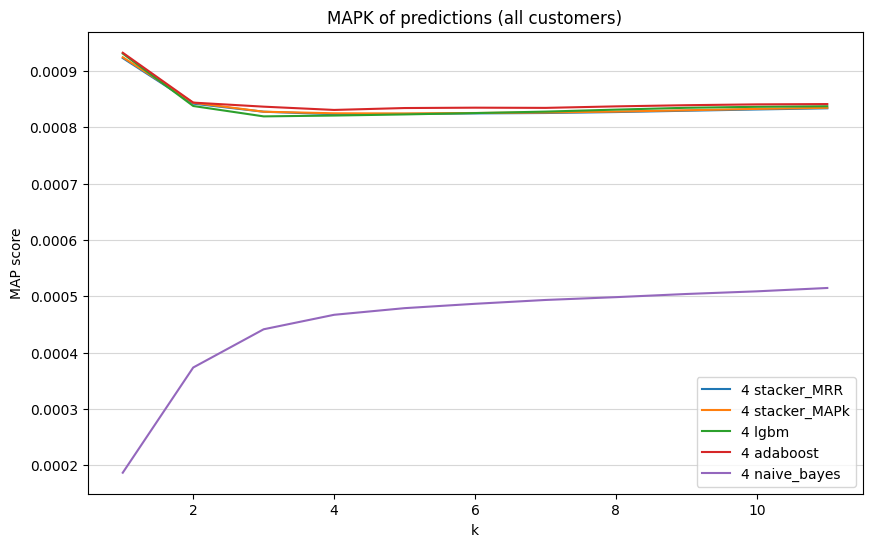

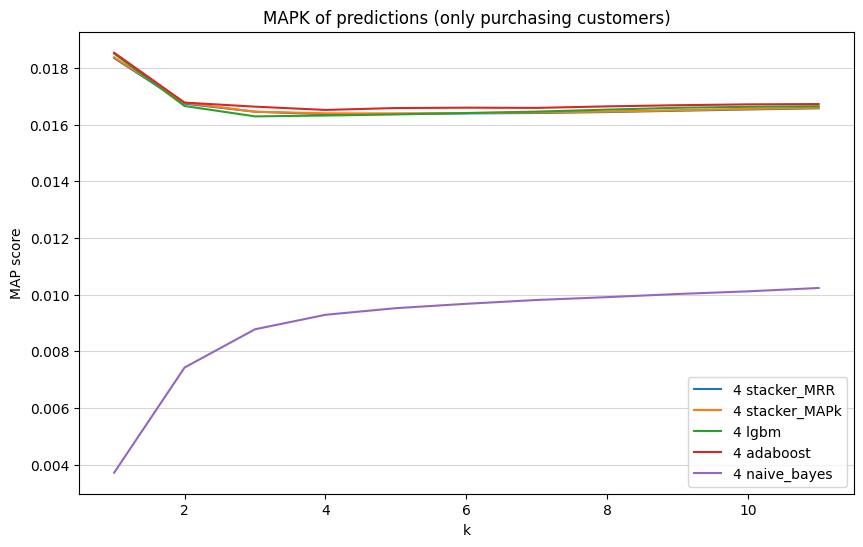

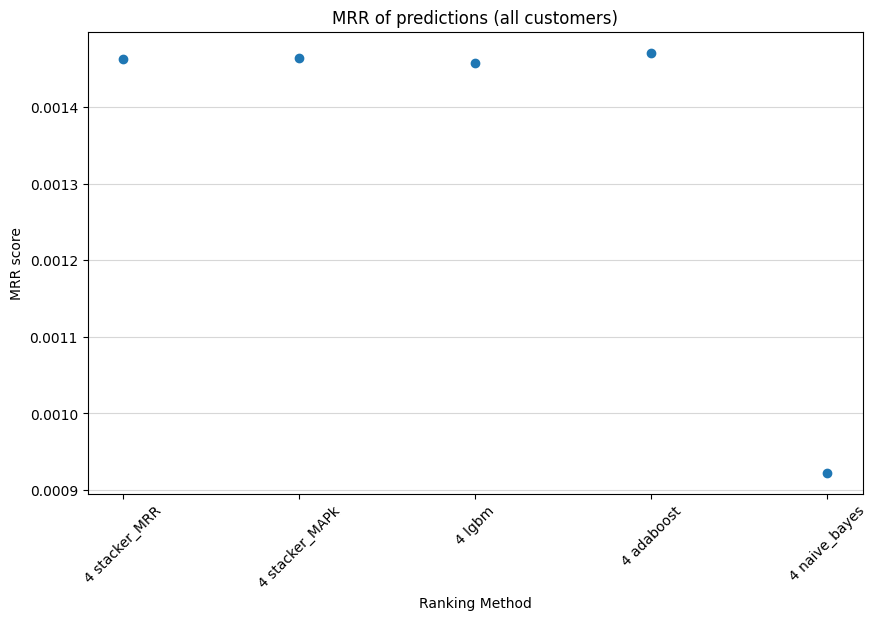

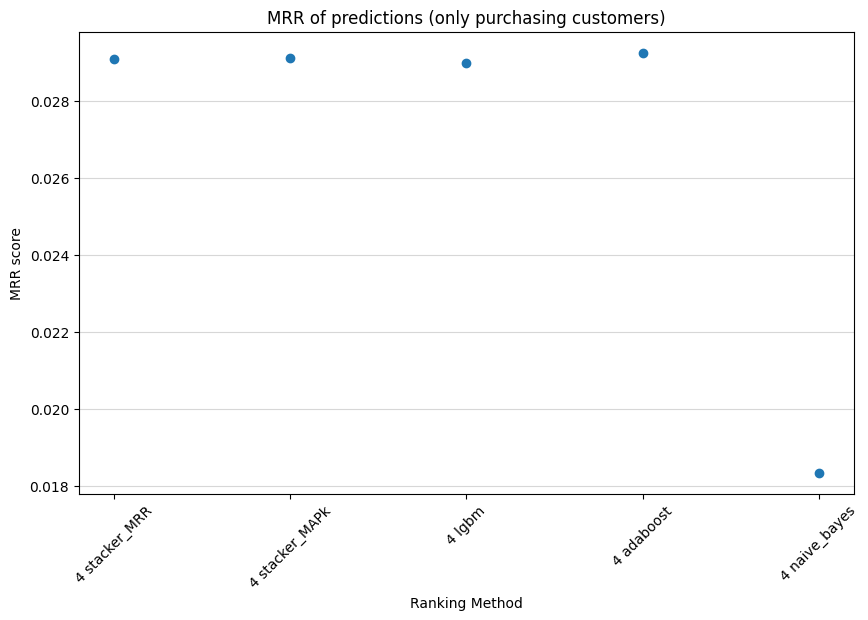

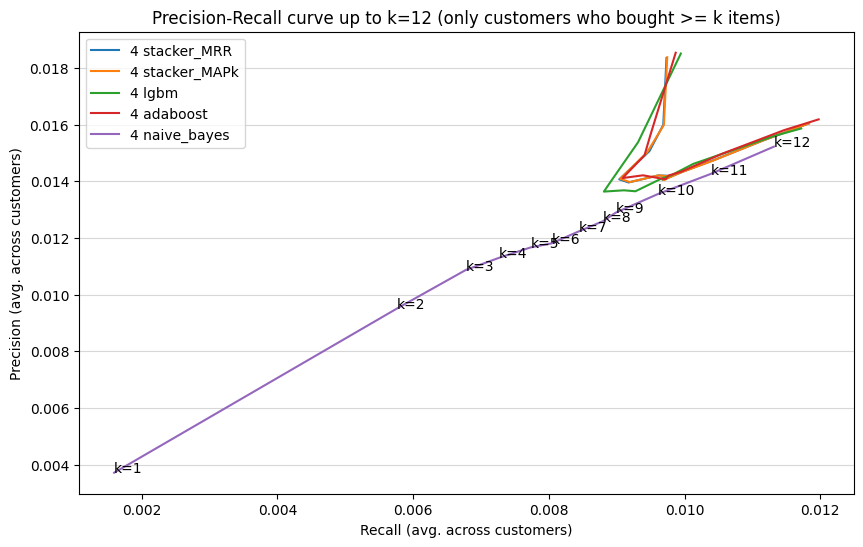

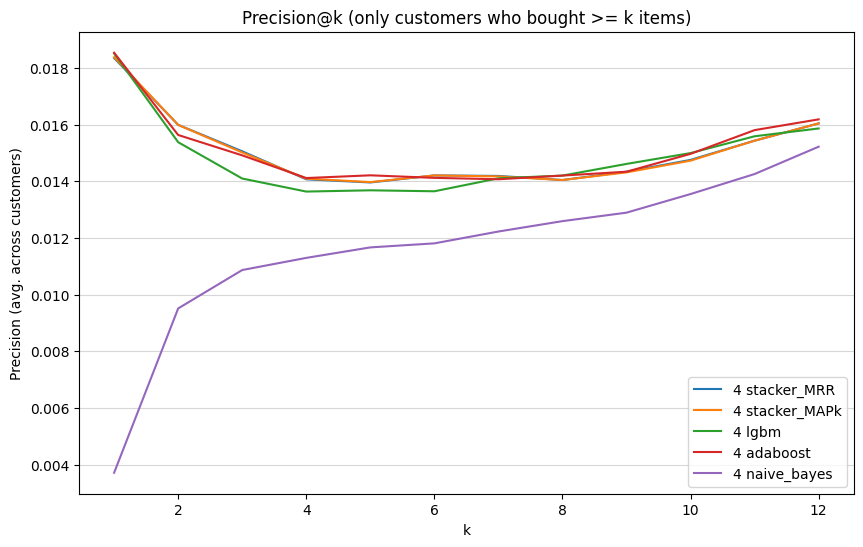

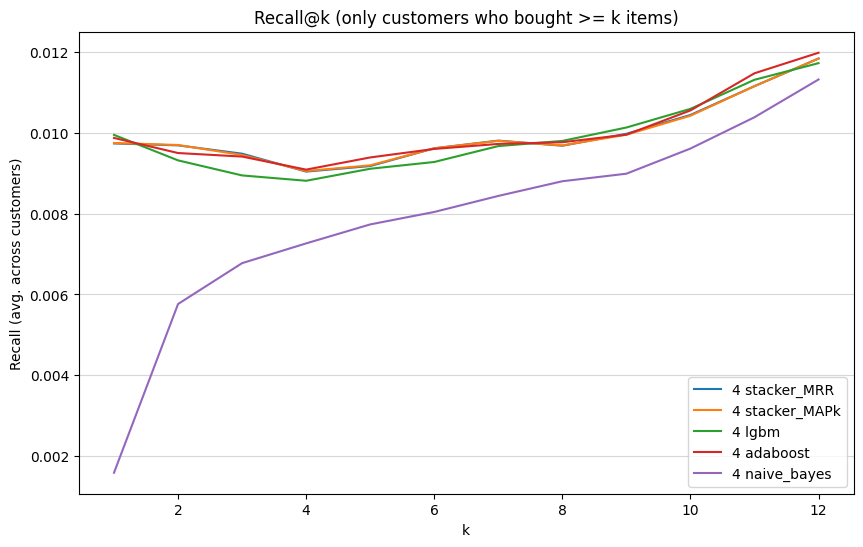

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


computing validation predictions for each of the base rankers...
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with MRR weighting
Predicting with MAPk weighting
Evaluation plots for 6 training weeks:
Evaluation for 6 stacker_MRR
####################

MAP@12 (all customers):             0.0008114038119803535
MAP@12 (only purchasing customers): 0.016137507276481583

MRR (all customers):                0.0014219709154401953
MRR (only purchasing customers):    0.02828069779319319



Evaluation for 6 stacker_MAPk
####################

MAP@12 (all customers):             0.0008105231917975649
MAP@12 (only purchasing customers): 0.016119993167726183

MRR (all customers):                0.0014215506561786992
MRR (only purchasing customers):    0.028272339517338107



Evaluation for 6 lgbm
####################

MAP@12 (all customers):             0.0008547263848767305
MAP@12 (only purchasing customers): 0.01699912306510461

MRR (all customers):  

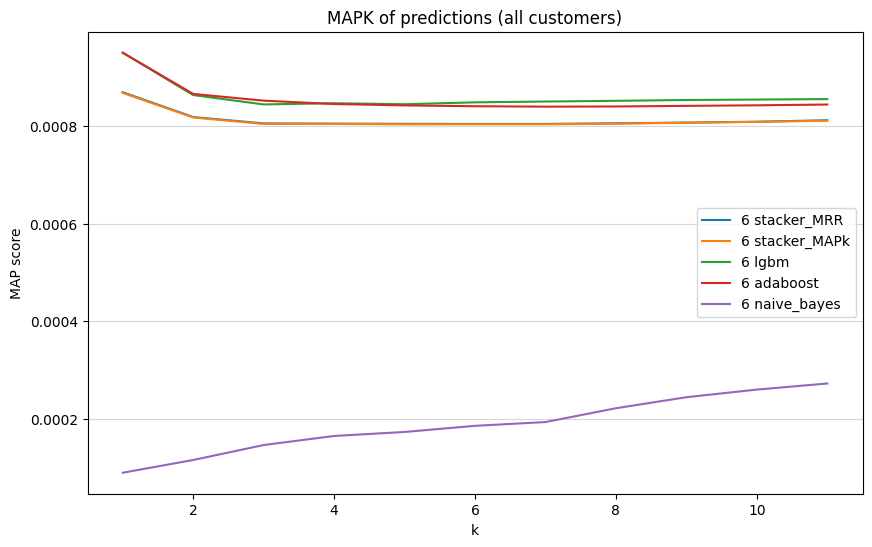

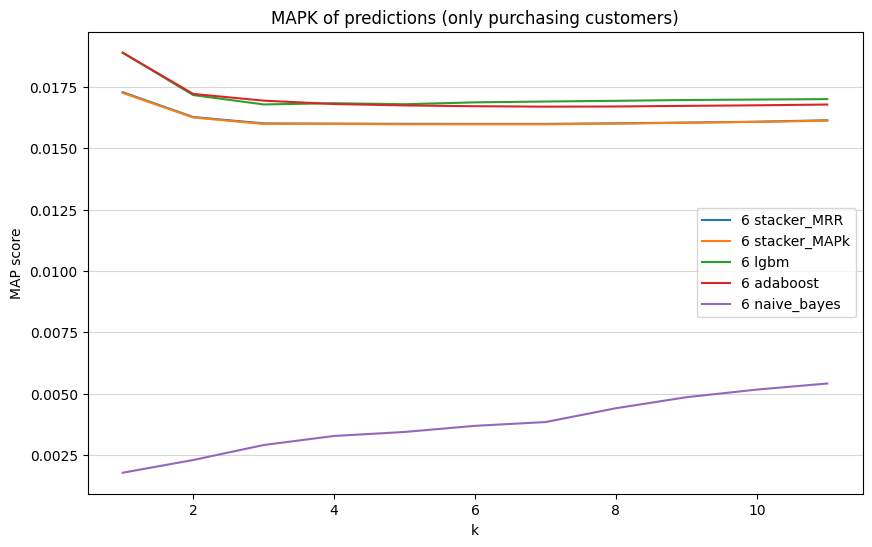

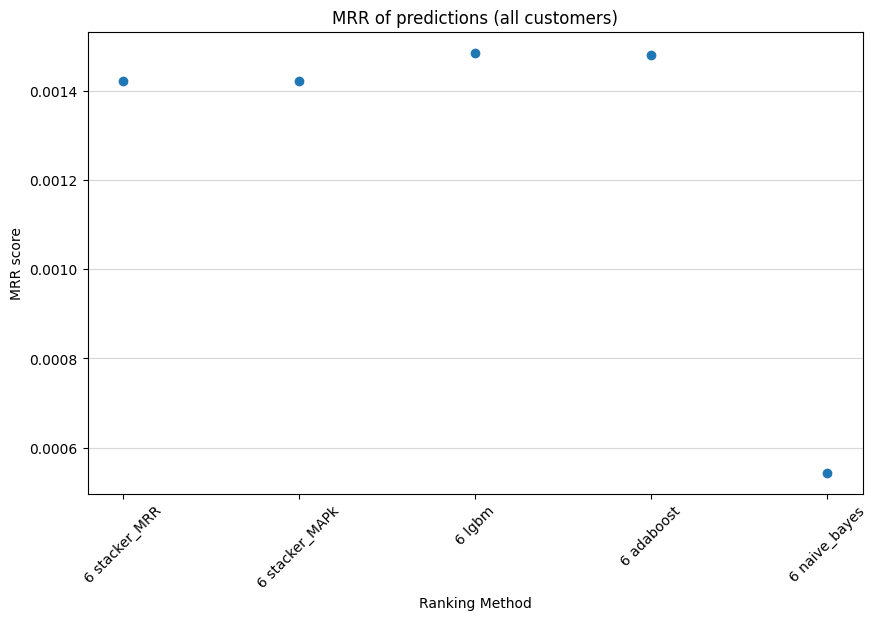

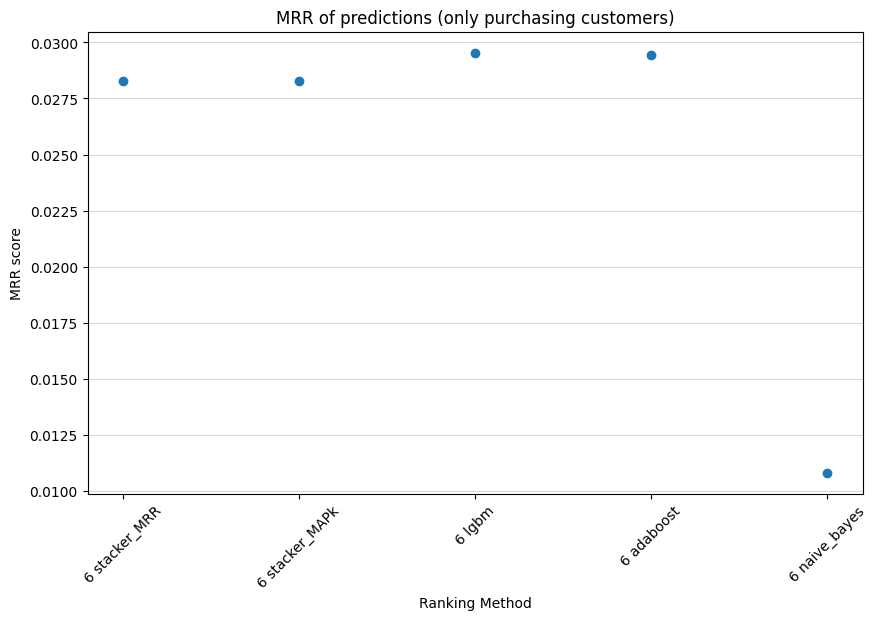

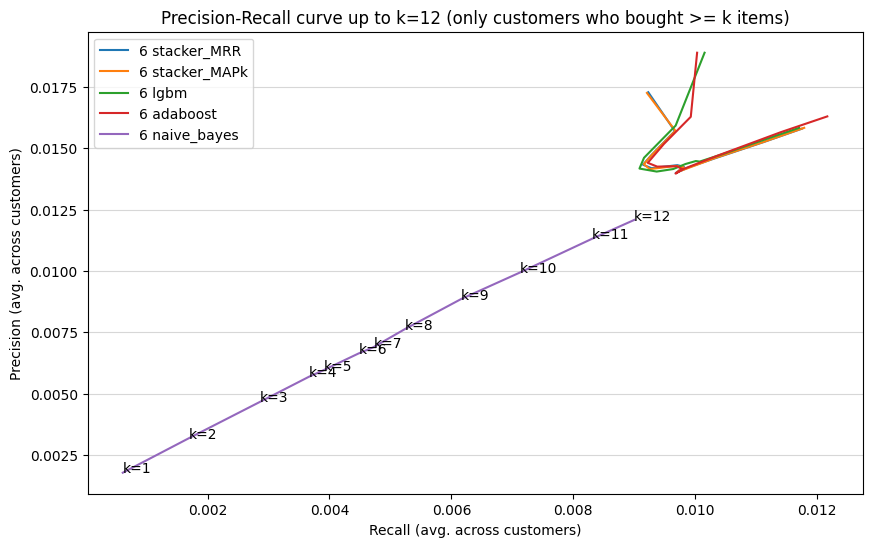

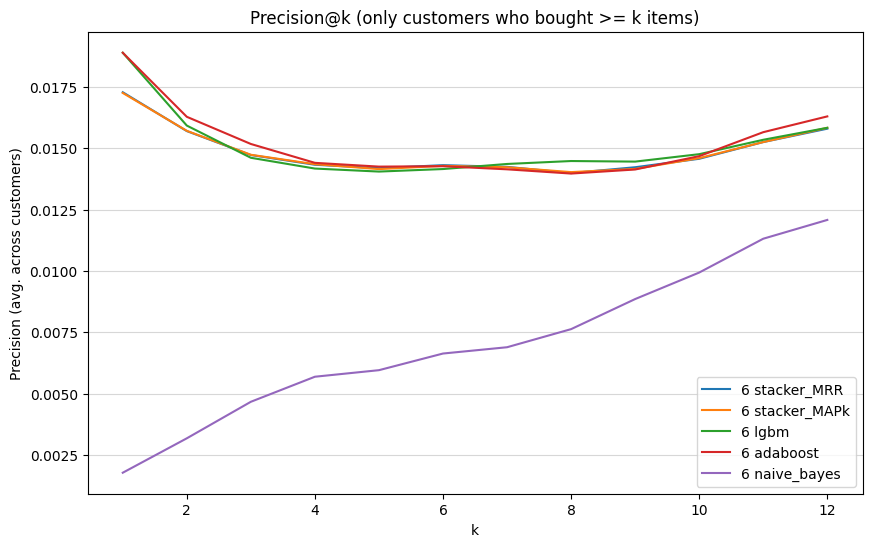

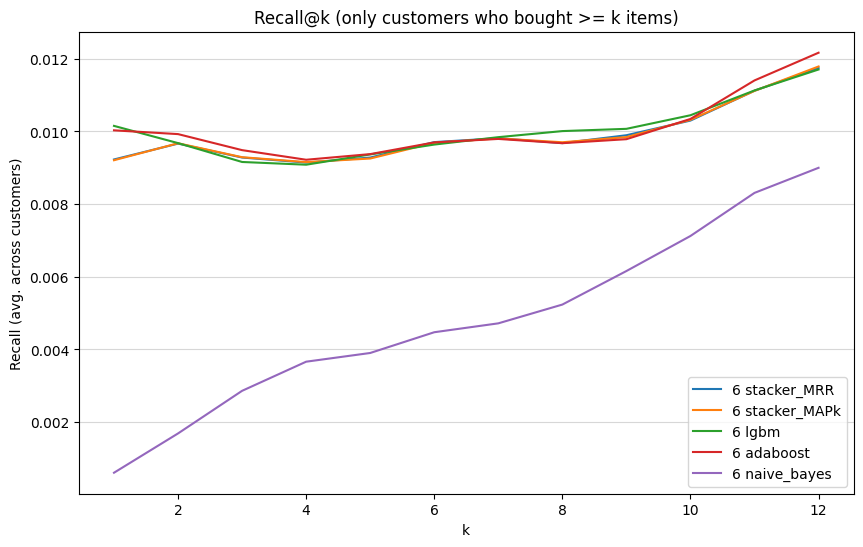

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


computing validation predictions for each of the base rankers...
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with MRR weighting
Predicting with MAPk weighting
Evaluation plots for 8 training weeks:
Evaluation for 8 stacker_MRR
####################

MAP@12 (all customers):             0.0008163245500601144
MAP@12 (only purchasing customers): 0.016235372784870052

MRR (all customers):                0.0014304299773657784
MRR (only purchasing customers):    0.02844893483048679



Evaluation for 8 stacker_MAPk
####################

MAP@12 (all customers):             0.0008201685645812886
MAP@12 (only purchasing customers): 0.016311824006062806

MRR (all customers):                0.0014378252309198683
MRR (only purchasing customers):    0.02859601444273224



Evaluation for 8 lgbm
####################

MAP@12 (all customers):             0.0008641269482626483
MAP@12 (only purchasing customers): 0.0171860850411311

MRR (all customers):    

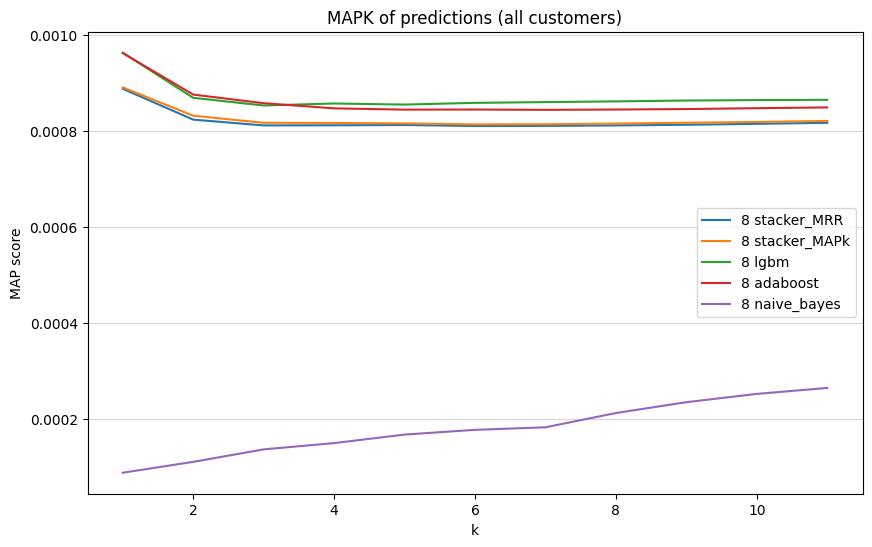

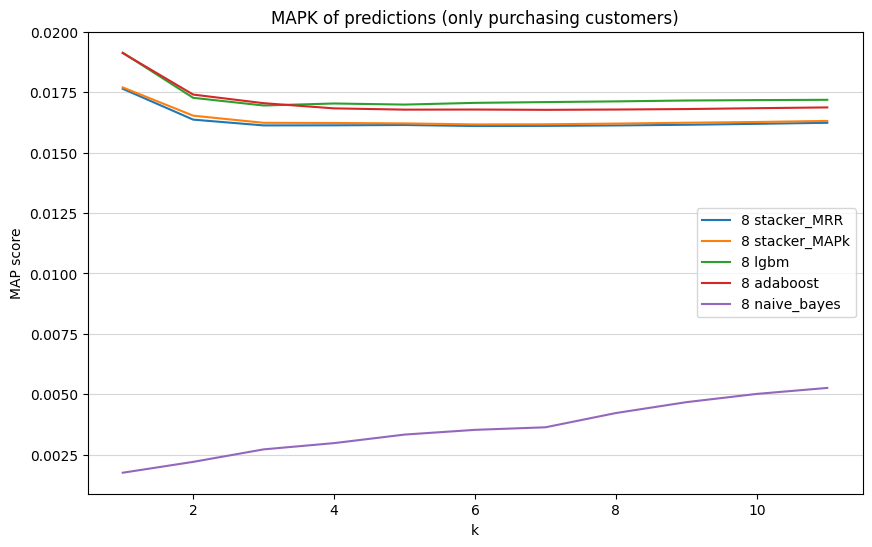

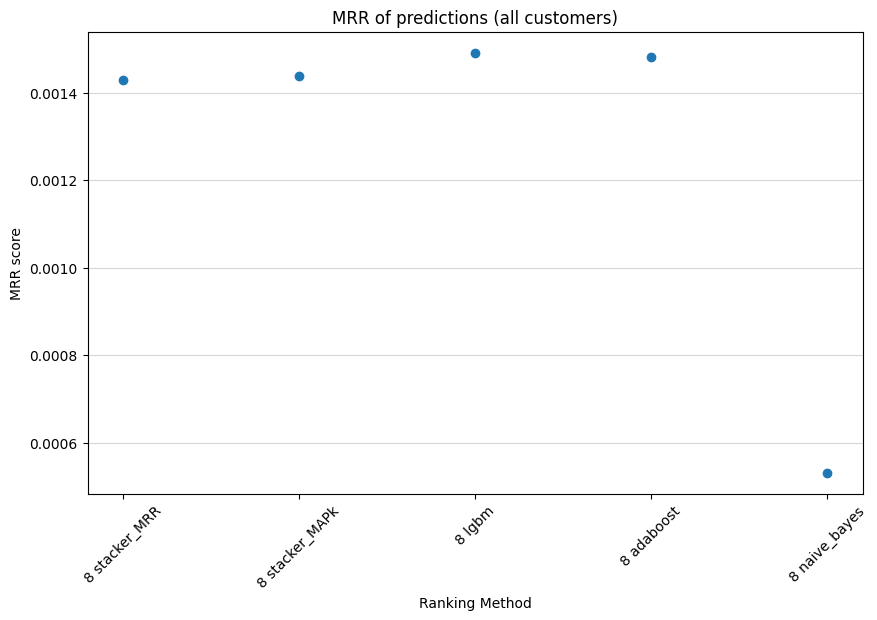

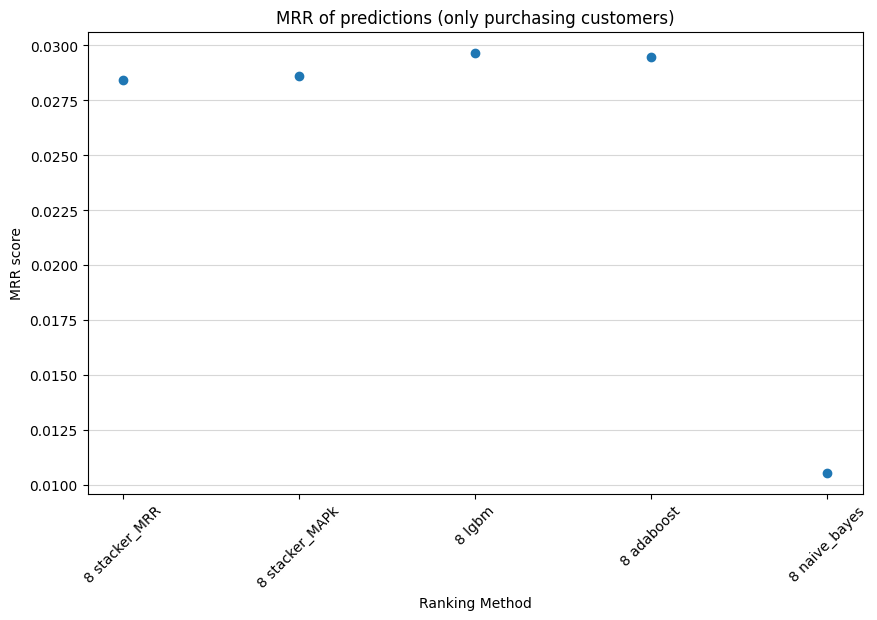

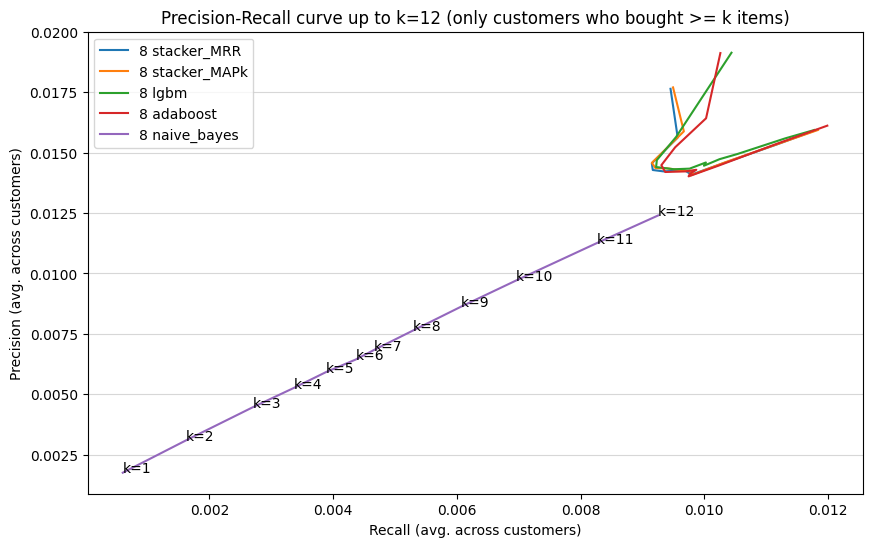

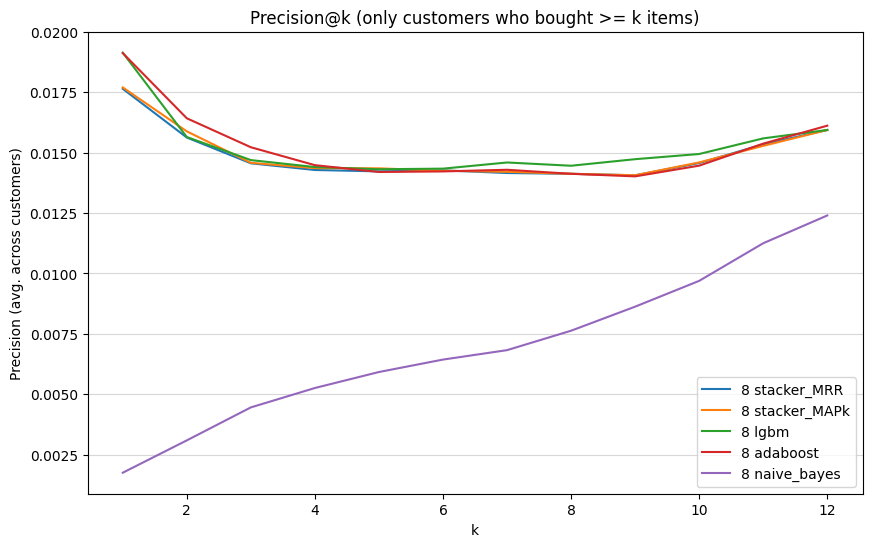

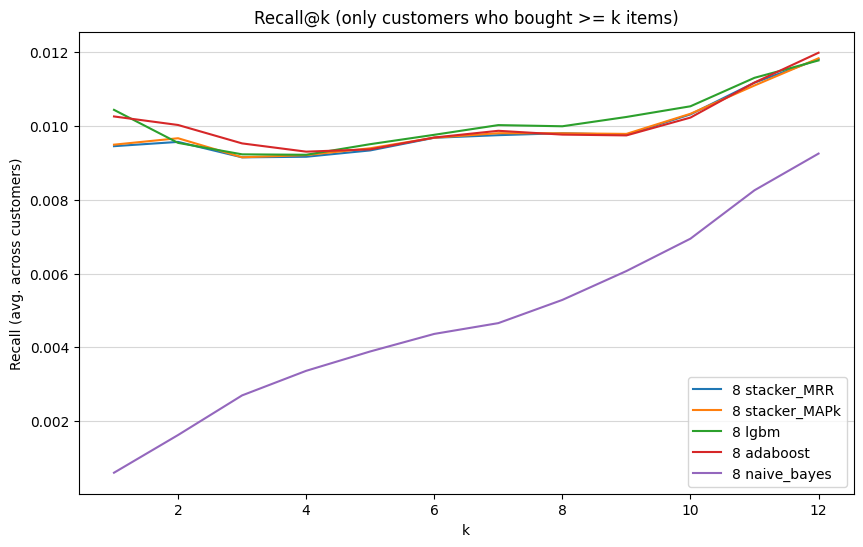

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


computing validation predictions for each of the base rankers...
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with MRR weighting
Predicting with MAPk weighting
Evaluation plots for 10 training weeks:
Evaluation for 10 stacker_MRR
####################

MAP@12 (all customers):             0.0008037057429744837
MAP@12 (only purchasing customers): 0.015984405155487255

MRR (all customers):                0.001401188525691058
MRR (only purchasing customers):    0.027867369730337727



Evaluation for 10 stacker_MAPk
####################

MAP@12 (all customers):             0.00080892938889787
MAP@12 (only purchasing customers): 0.016088295010148728

MRR (all customers):                0.0014091598312942532
MRR (only purchasing customers):    0.028025906084586126



Evaluation for 10 lgbm
####################

MAP@12 (all customers):             0.0008622319770332917
MAP@12 (only purchasing customers): 0.01714839713339522

MRR (all customers):

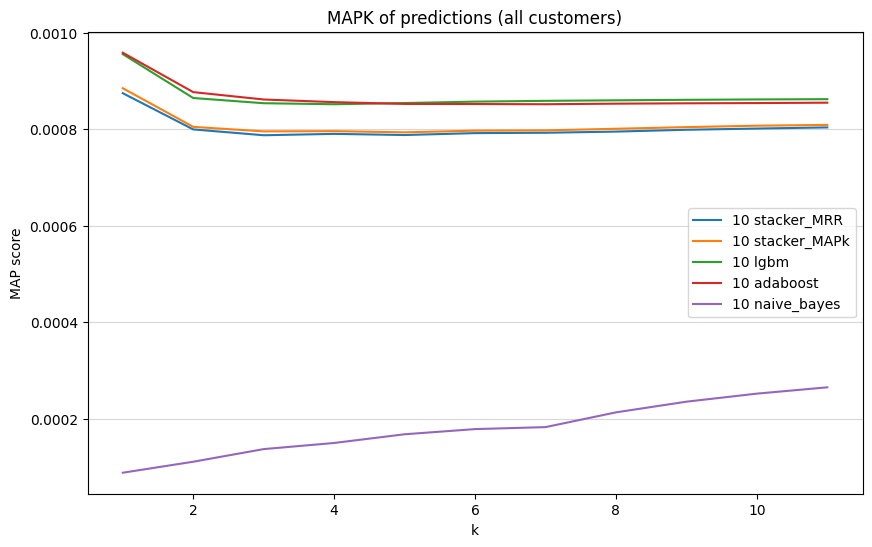

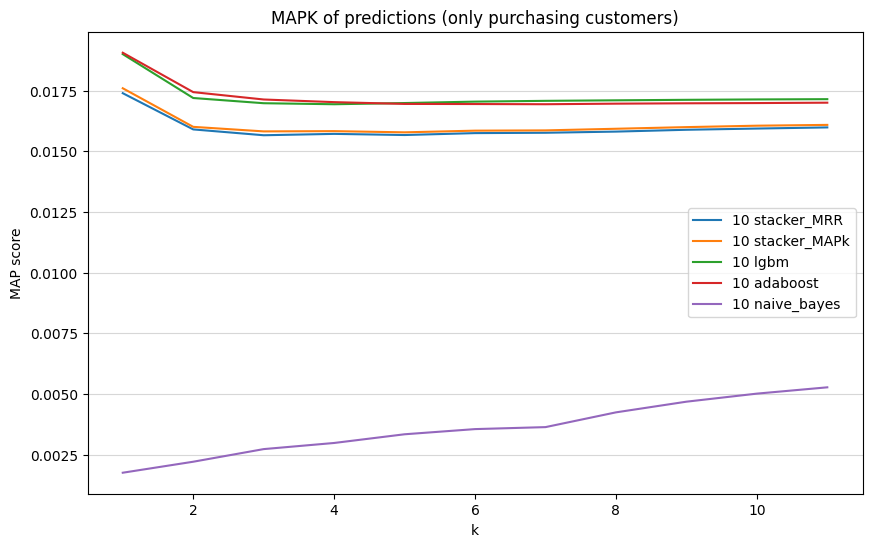

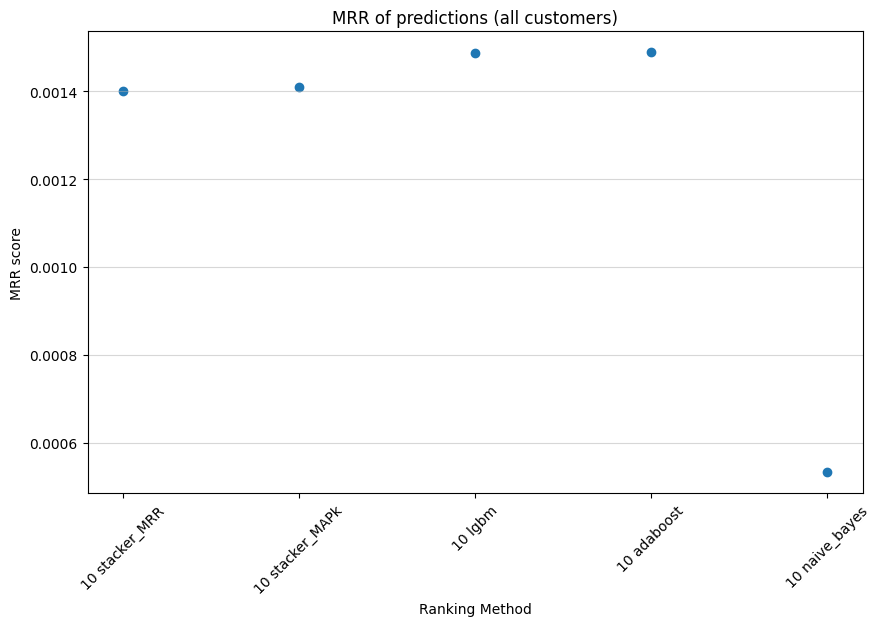

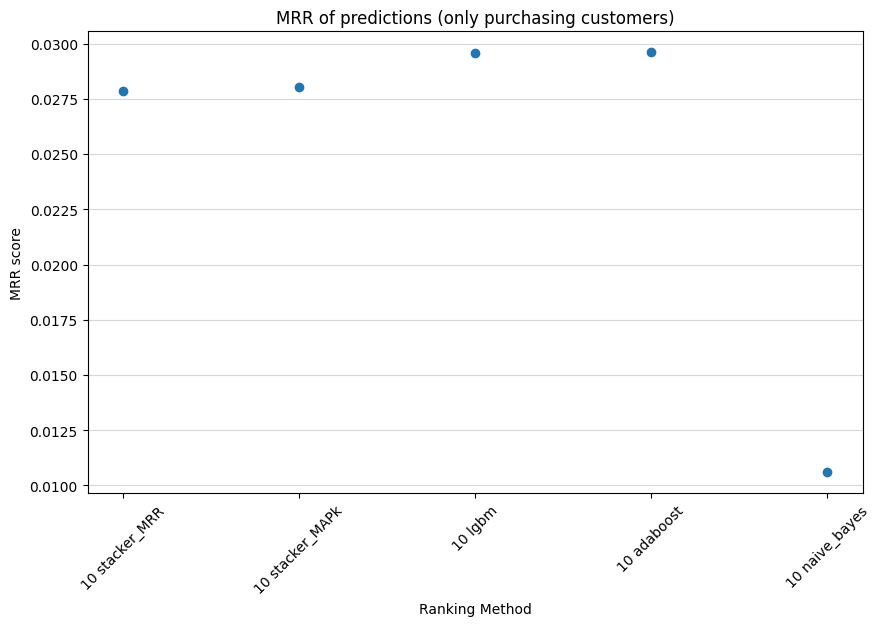

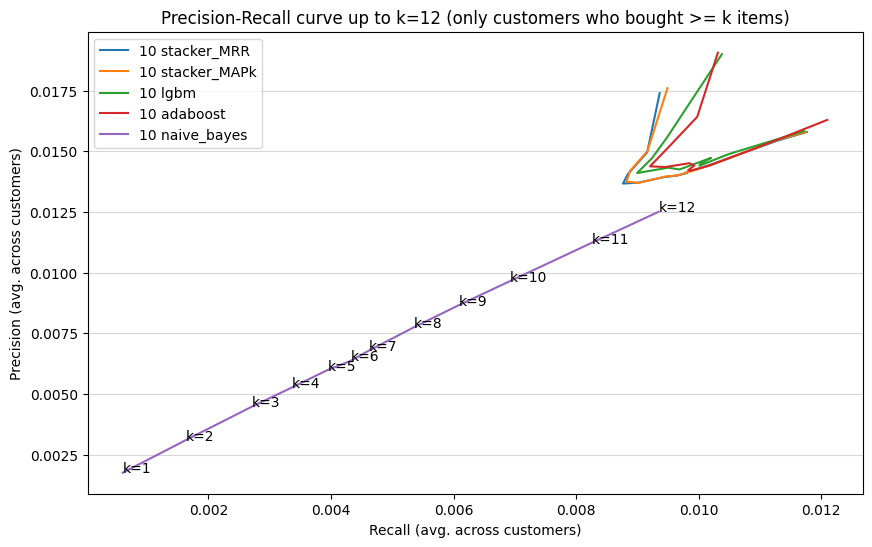

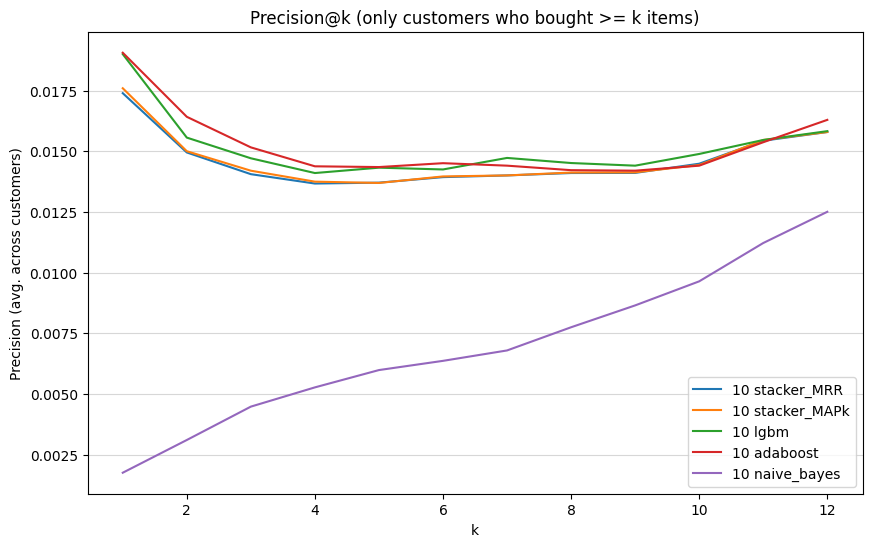

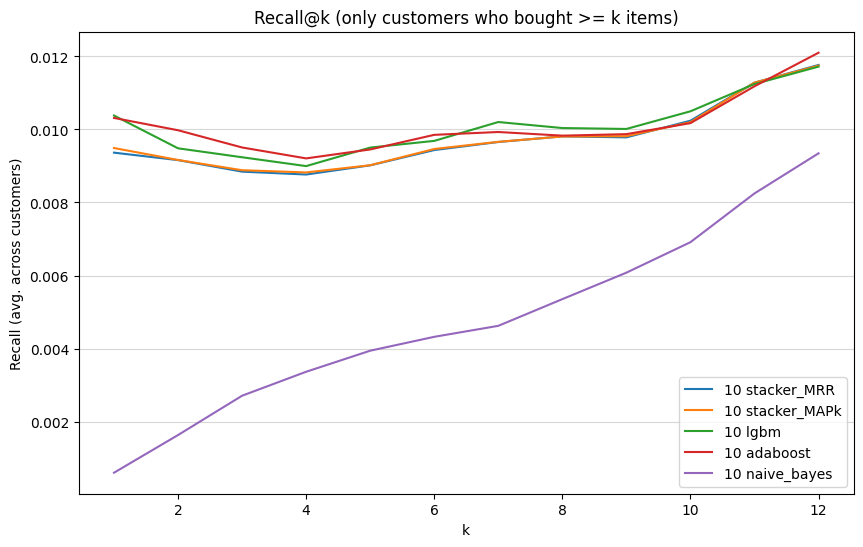

/home/peter/data_science/Year2/AI Project/Project/ai-project-23-24/PeterKirby/PrepareData.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['purchased'] = 1                                   #this cell produces a warning, but can be ignored as we use "transactions" slice to produce the returned dataframe


computing validation predictions for each of the base rankers...
Computing scores on validatation...
retraining base rankers on full training set...
Predicting with MRR weighting
Predicting with MAPk weighting
Evaluation plots for 12 training weeks:
Evaluation for 12 stacker_MRR
####################

MAP@12 (all customers):             0.0008133832701731349
MAP@12 (only purchasing customers): 0.016176875493043853

MRR (all customers):                0.001422386809874224
MRR (only purchasing customers):    0.028288969259701348



Evaluation for 12 stacker_MAPk
####################

MAP@12 (all customers):             0.000820192814054369
MAP@12 (only purchasing customers): 0.016312306288796145

MRR (all customers):                0.0014353390672651766
MRR (only purchasing customers):    0.0285465686754389



Evaluation for 12 lgbm
####################

MAP@12 (all customers):             0.0008679056776018472
MAP@12 (only purchasing customers): 0.01726123784582196

MRR (all customers): 

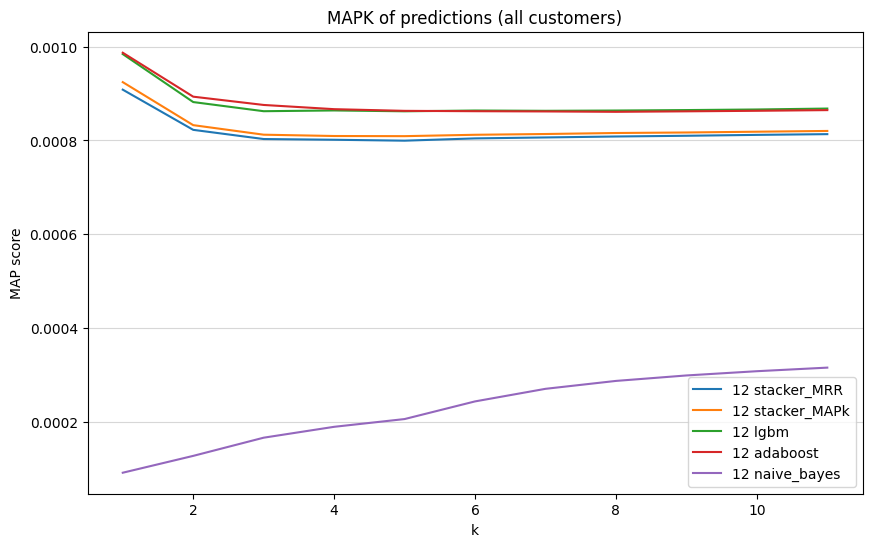

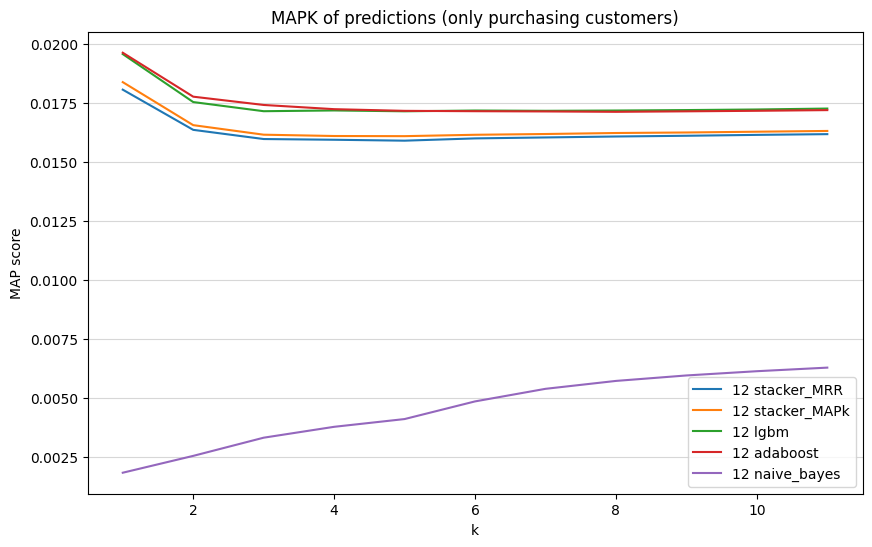

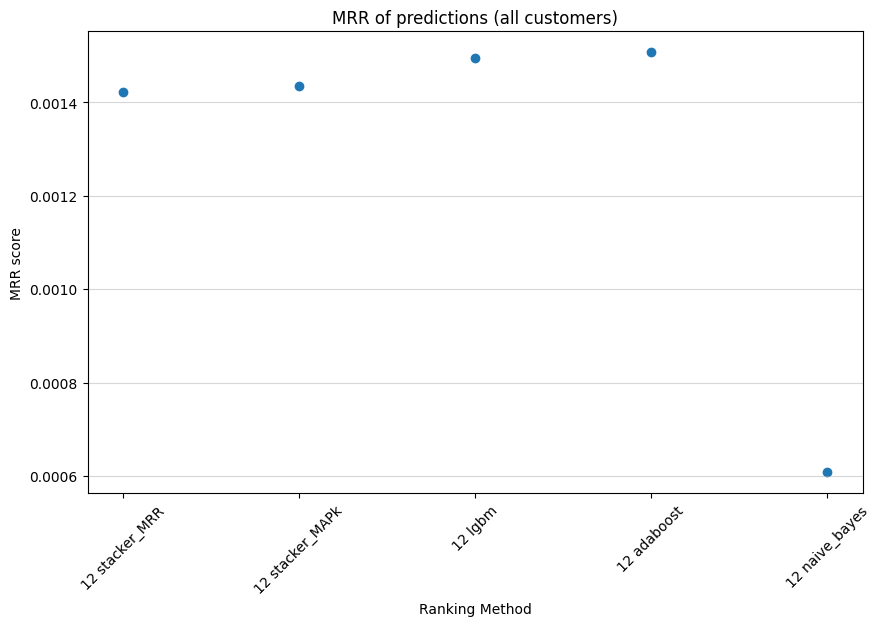

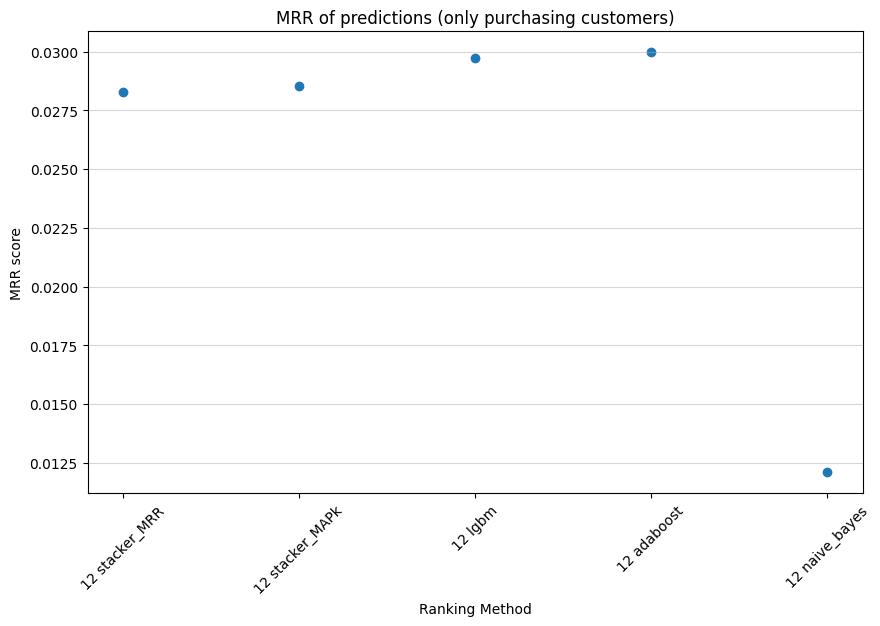

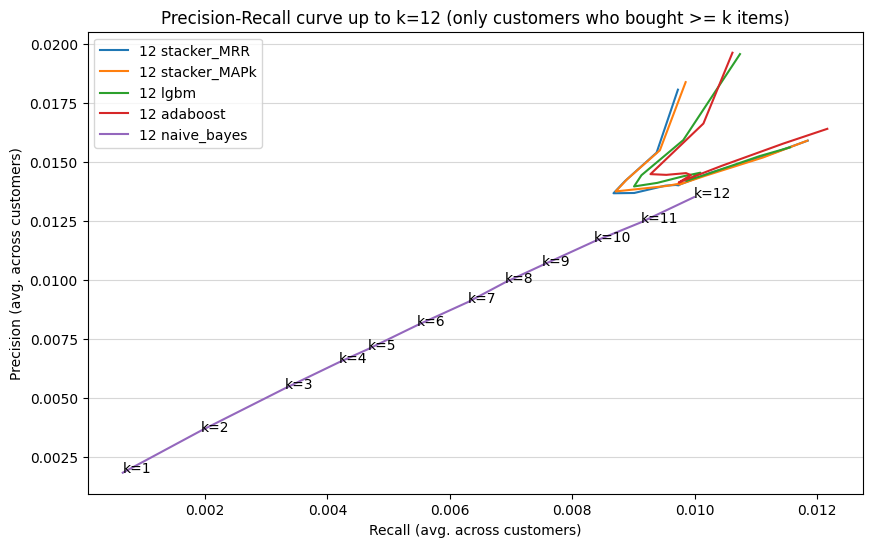

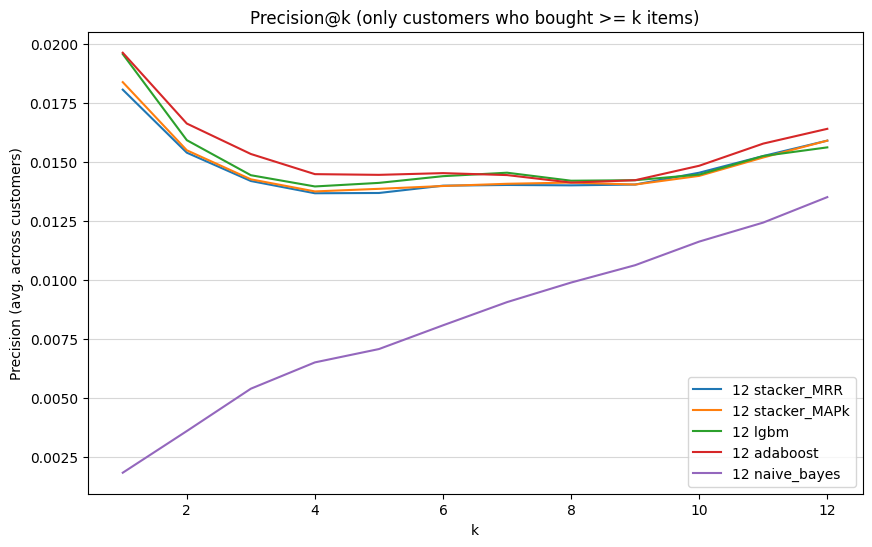

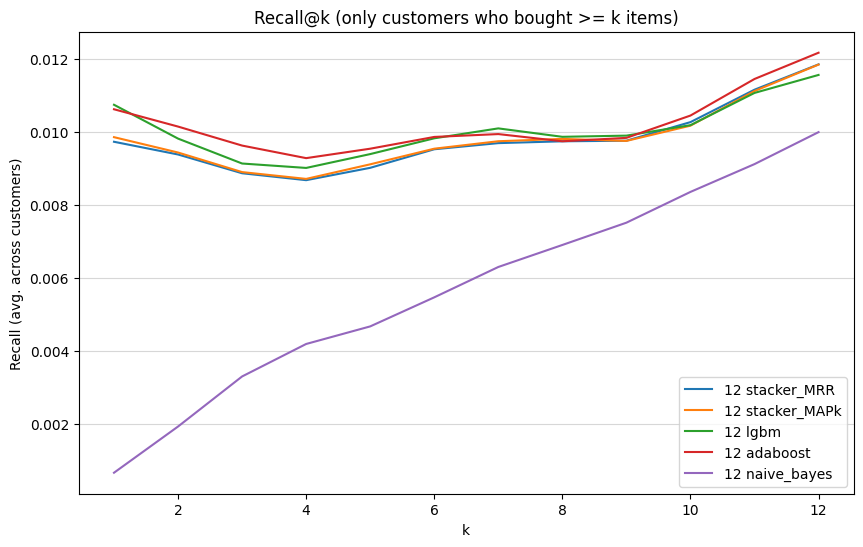

In [8]:
#graphs show how the different models (base rankers and stacking variation) perform with different numbers of training/validation weeks
fit_and_eval(training_weeks_range, test)

Base rankers always seem to give the highest scores with smaller training sets. (Other experiments used 10 weeks of training data with 5 weeks of training for validation and showed stackers performing better relative to base rankers)

Evaluation plots for stacker_MRR:
Evaluation for 4 stacker_MRR
####################

MAP@12 (all customers):             0.0008335539916163613
MAP@12 (only purchasing customers): 0.016578038464249892

MRR (all customers):                0.0014622409714174778
MRR (only purchasing customers):    0.029081603965634802



Evaluation for 6 stacker_MRR
####################

MAP@12 (all customers):             0.0008114038119803535
MAP@12 (only purchasing customers): 0.016137507276481583

MRR (all customers):                0.0014219709154401953
MRR (only purchasing customers):    0.02828069779319319



Evaluation for 8 stacker_MRR
####################

MAP@12 (all customers):             0.0008163245500601144
MAP@12 (only purchasing customers): 0.016235372784870052

MRR (all customers):                0.0014304299773657784
MRR (only purchasing customers):    0.02844893483048679



Evaluation for 10 stacker_MRR
####################

MAP@12 (all customers):             0.0008037057429744837
MAP

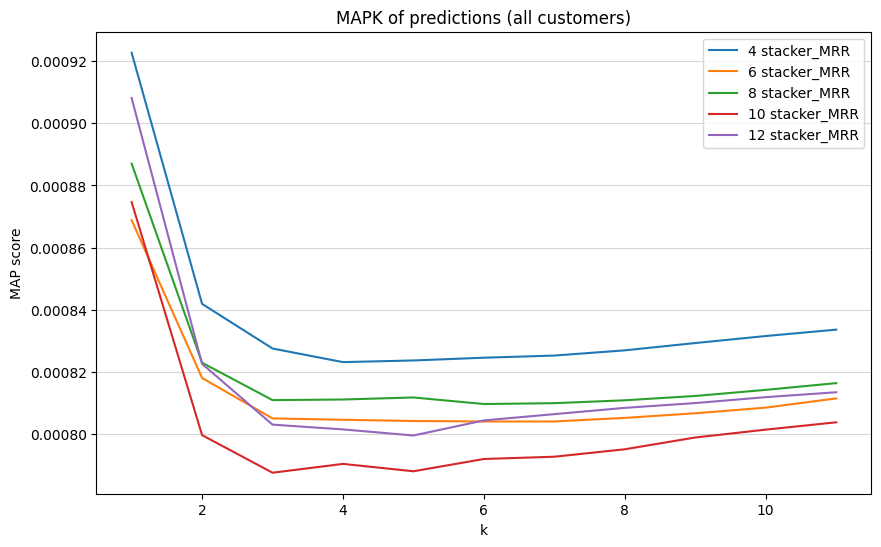

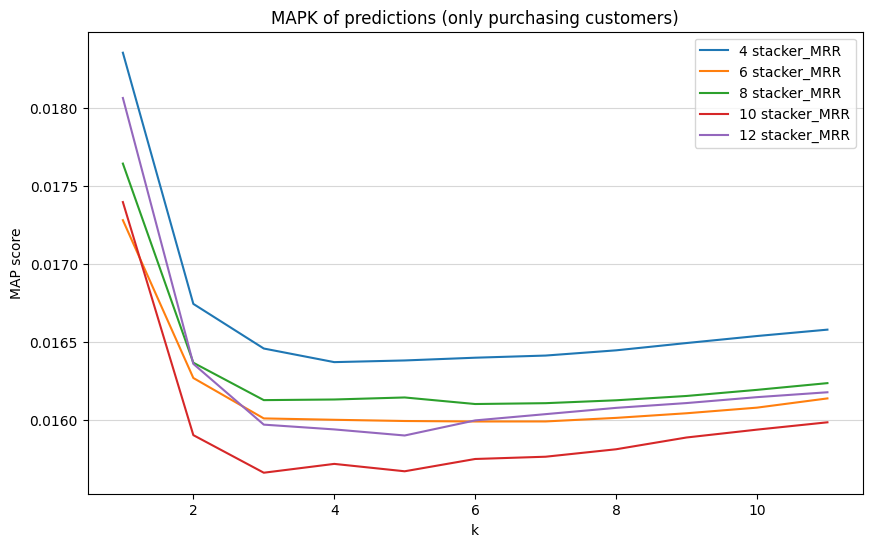

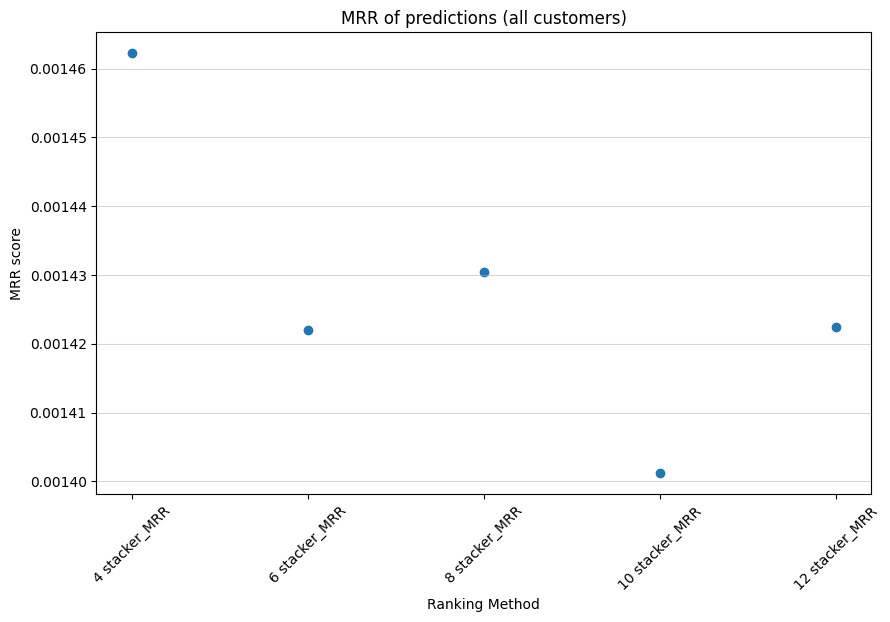

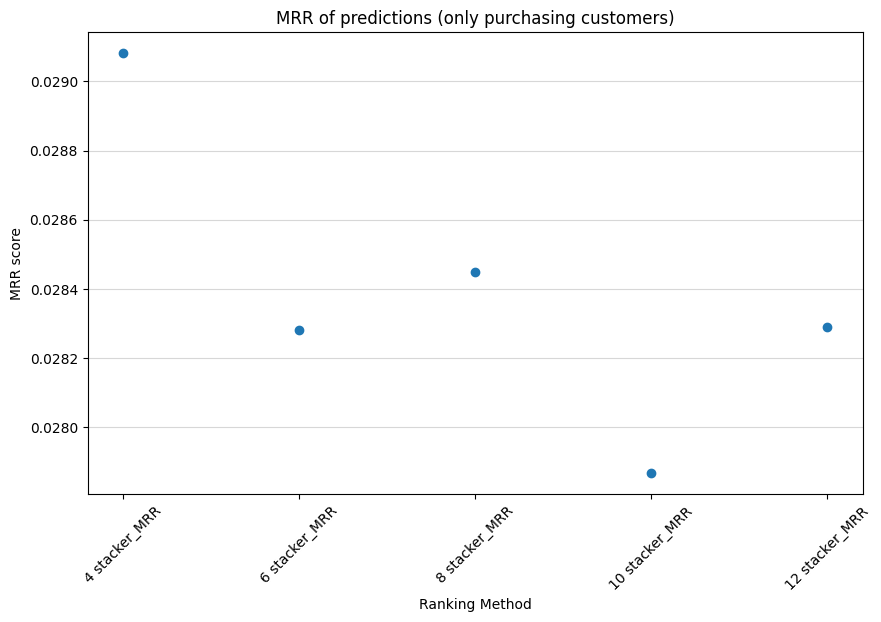

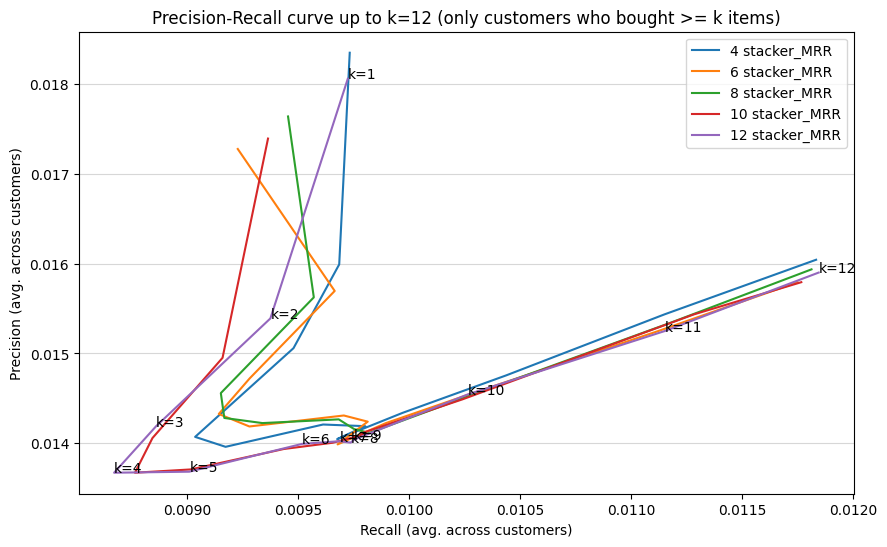

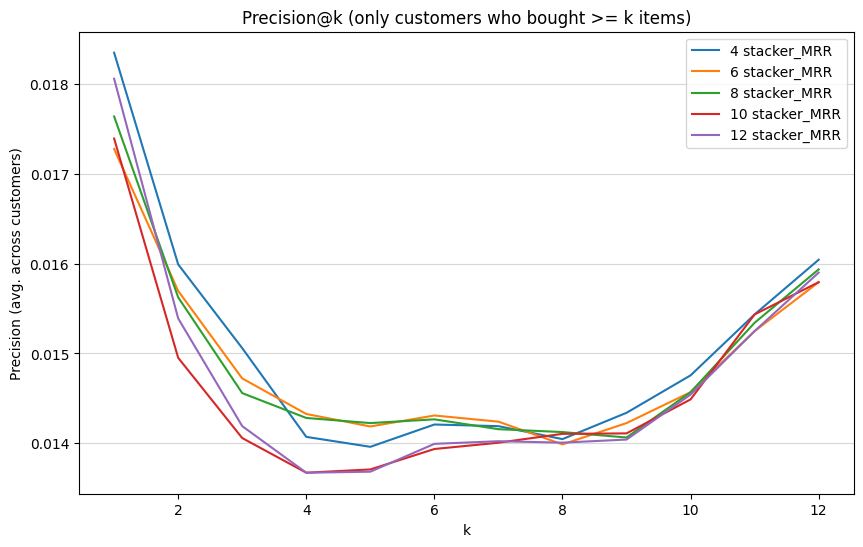

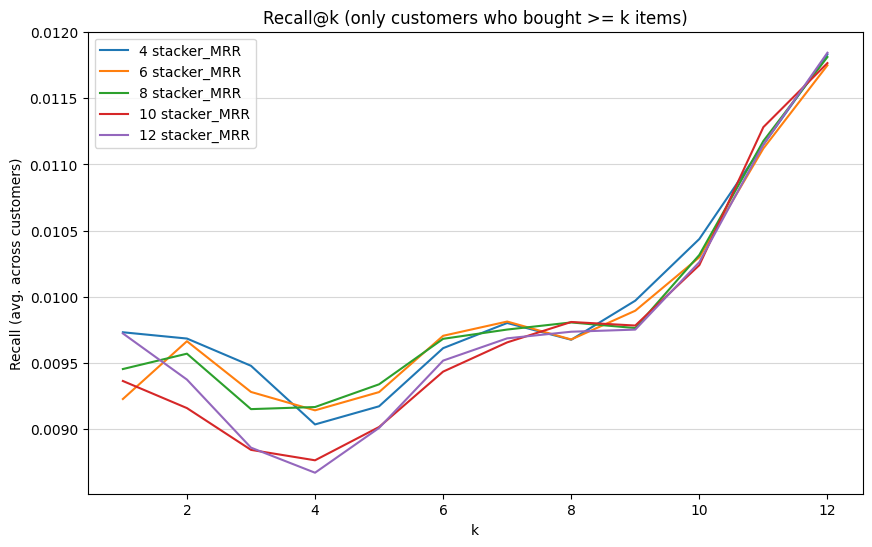

Evaluation plots for stacker_MAPk:
Evaluation for 4 stacker_MAPk
####################

MAP@12 (all customers):             0.000834457068509784
MAP@12 (only purchasing customers): 0.016595999200598004

MRR (all customers):                0.0014636320892607304
MRR (only purchasing customers):    0.02910927104580681



Evaluation for 6 stacker_MAPk
####################

MAP@12 (all customers):             0.0008105231917975649
MAP@12 (only purchasing customers): 0.016119993167726183

MRR (all customers):                0.0014215506561786992
MRR (only purchasing customers):    0.028272339517338107



Evaluation for 8 stacker_MAPk
####################

MAP@12 (all customers):             0.0008201685645812886
MAP@12 (only purchasing customers): 0.016311824006062806

MRR (all customers):                0.0014378252309198683
MRR (only purchasing customers):    0.02859601444273224



Evaluation for 10 stacker_MAPk
####################

MAP@12 (all customers):             0.00080892938889787
M

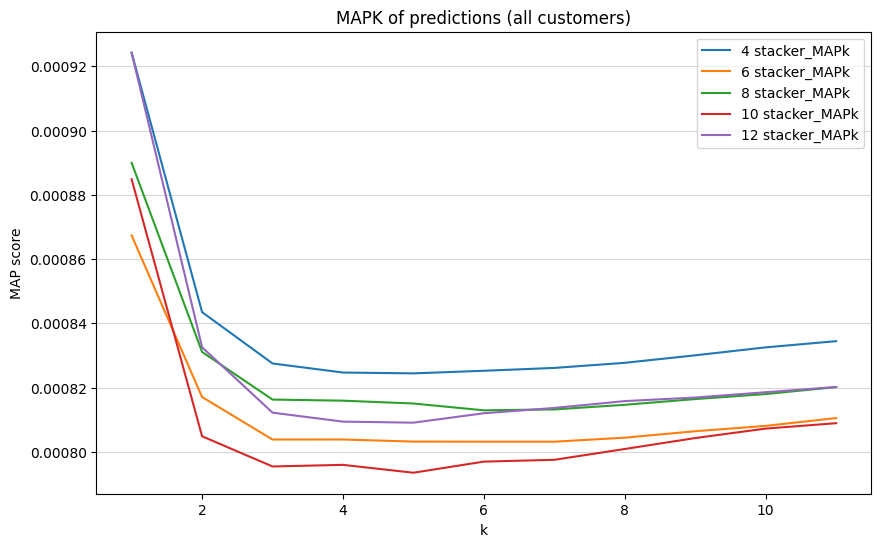

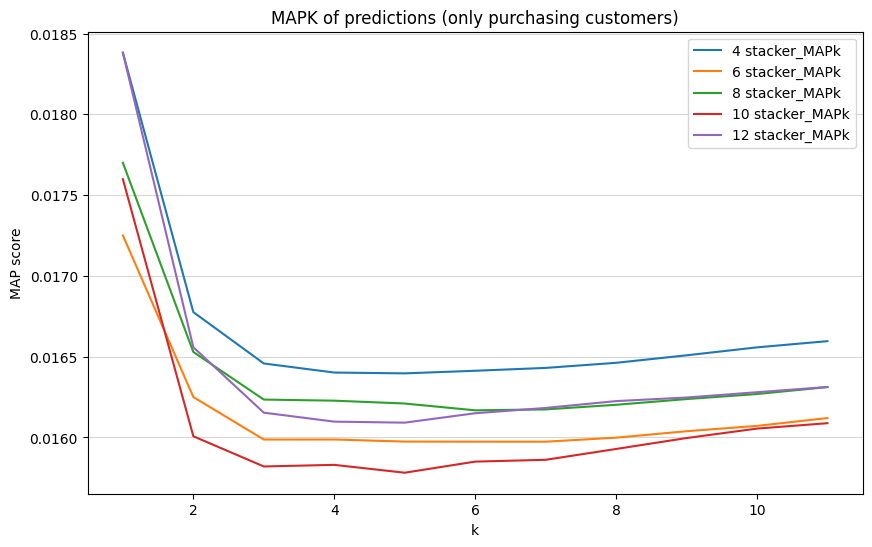

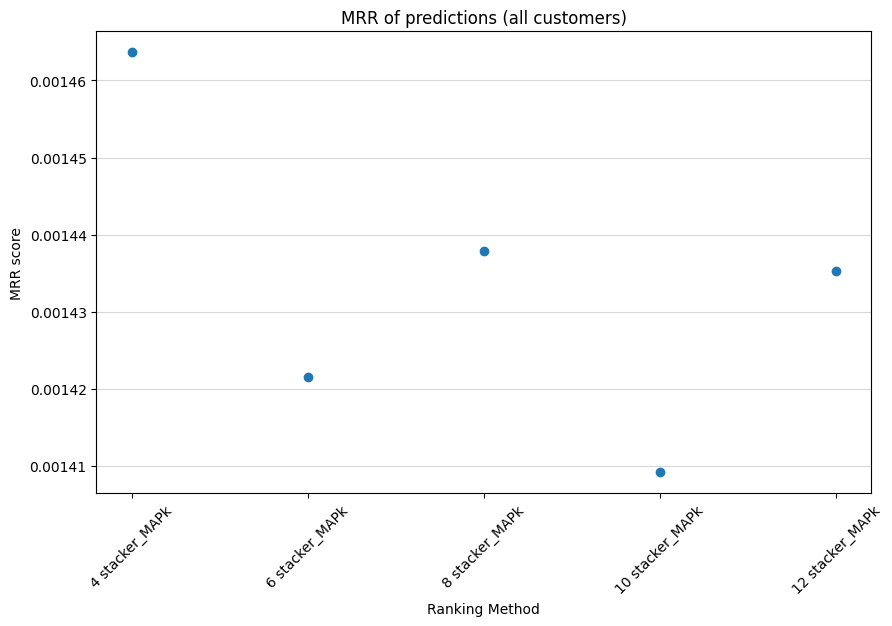

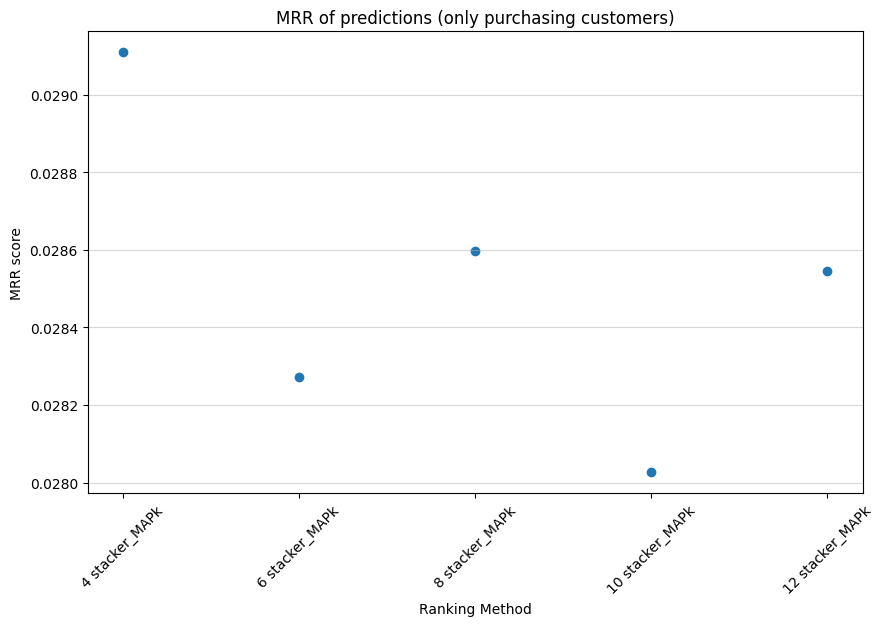

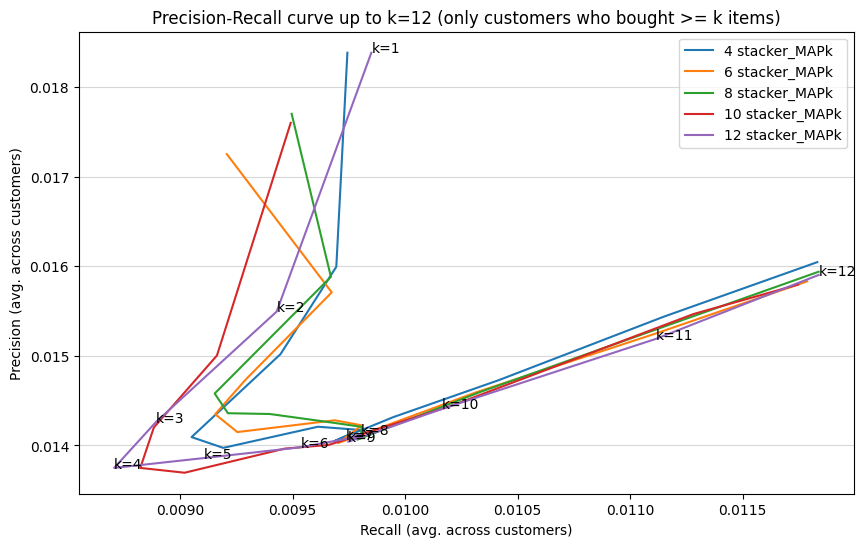

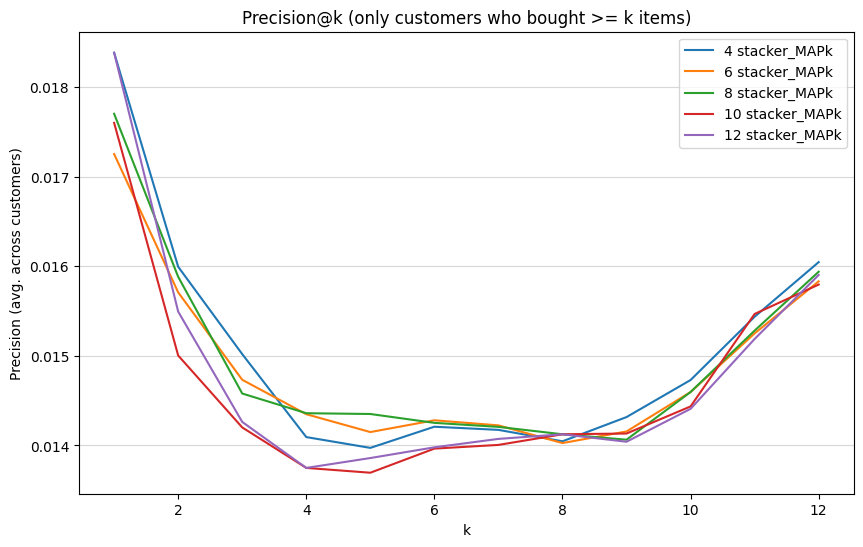

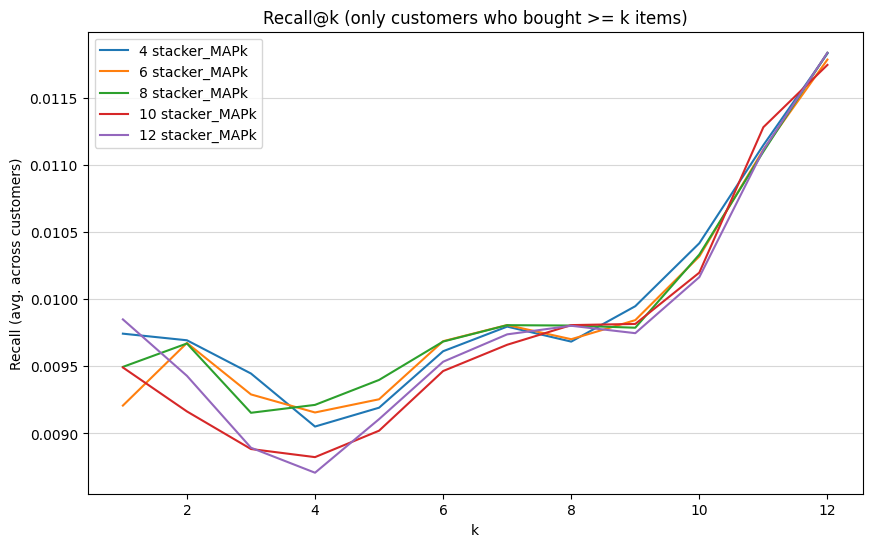

Evaluation plots for lgbm:
Evaluation for 4 lgbm
####################

MAP@12 (all customers):             0.0008372439401882545
MAP@12 (only purchasing customers): 0.016651425563311513

MRR (all customers):                0.0014576274276670675
MRR (only purchasing customers):    0.02898984805477594



Evaluation for 6 lgbm
####################

MAP@12 (all customers):             0.0008547263848767305
MAP@12 (only purchasing customers): 0.01699912306510461

MRR (all customers):                0.001485528167367543
MRR (only purchasing customers):    0.029544748565825726



Evaluation for 8 lgbm
####################

MAP@12 (all customers):             0.0008641269482626483
MAP@12 (only purchasing customers): 0.0171860850411311

MRR (all customers):                0.00149190654759248
MRR (only purchasing customers):    0.029671604214976378



Evaluation for 10 lgbm
####################

MAP@12 (all customers):             0.0008622319770332917
MAP@12 (only purchasing customers): 0.01714

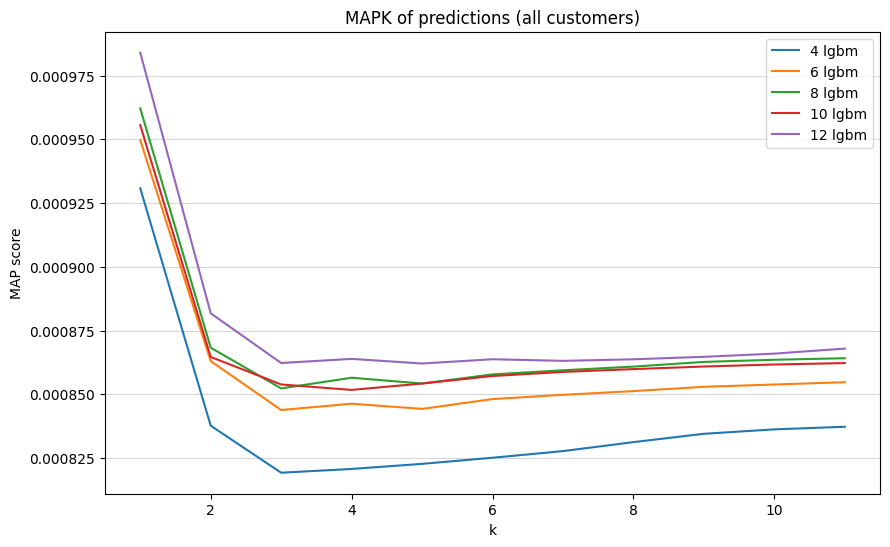

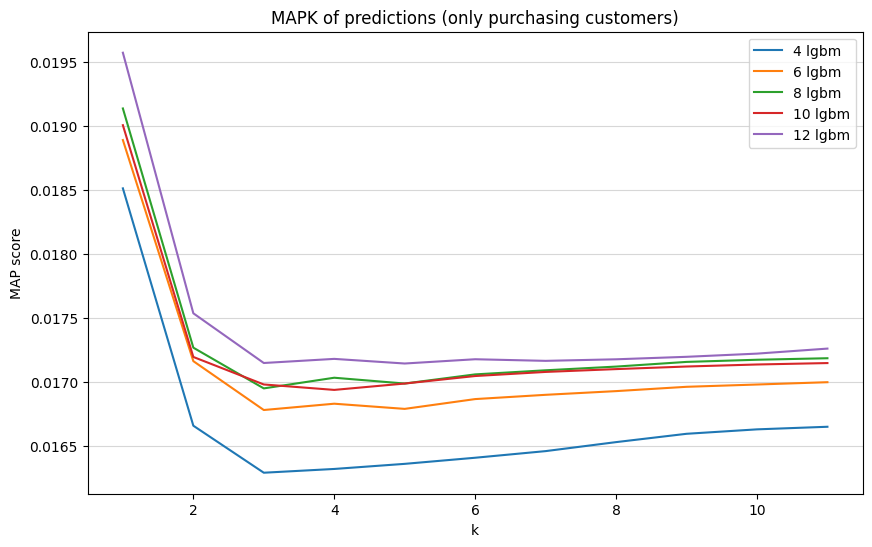

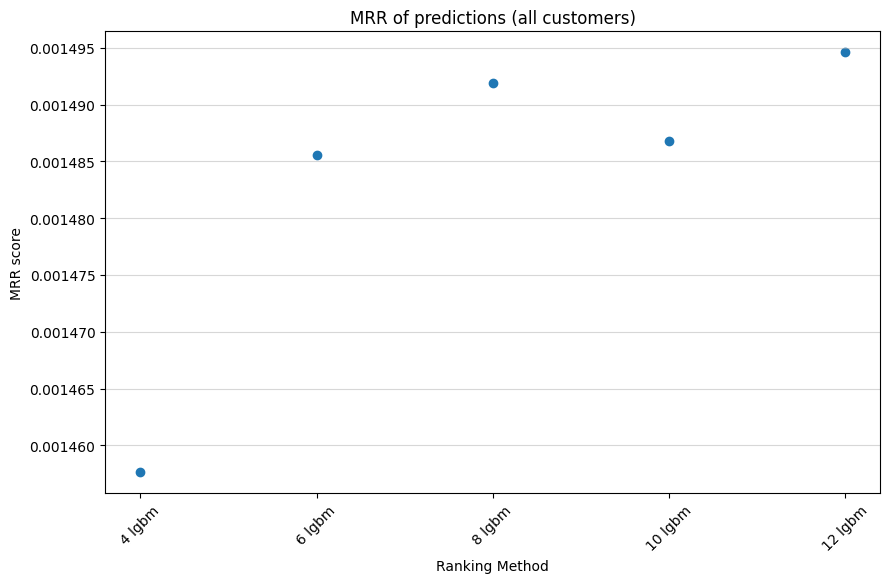

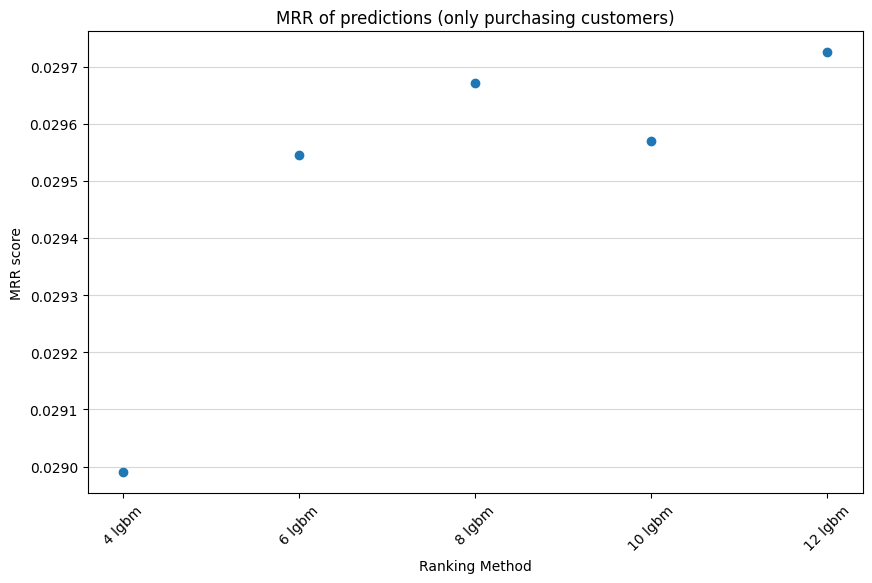

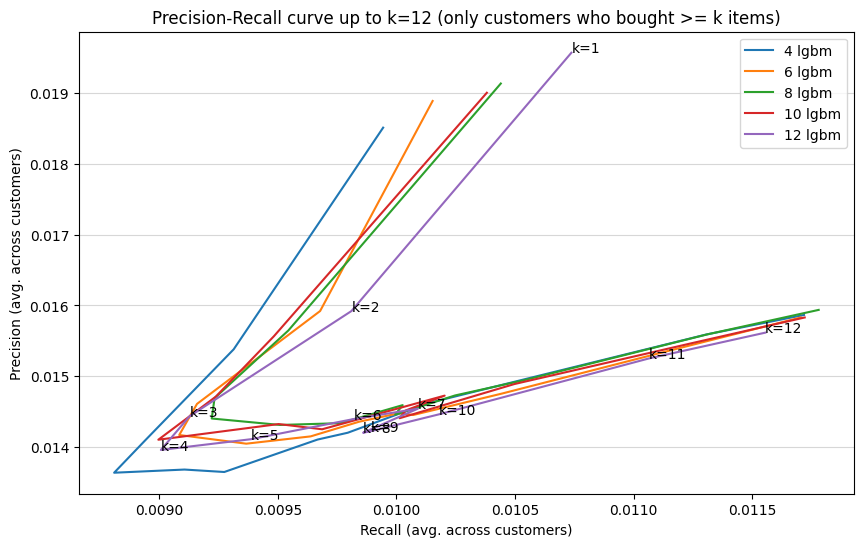

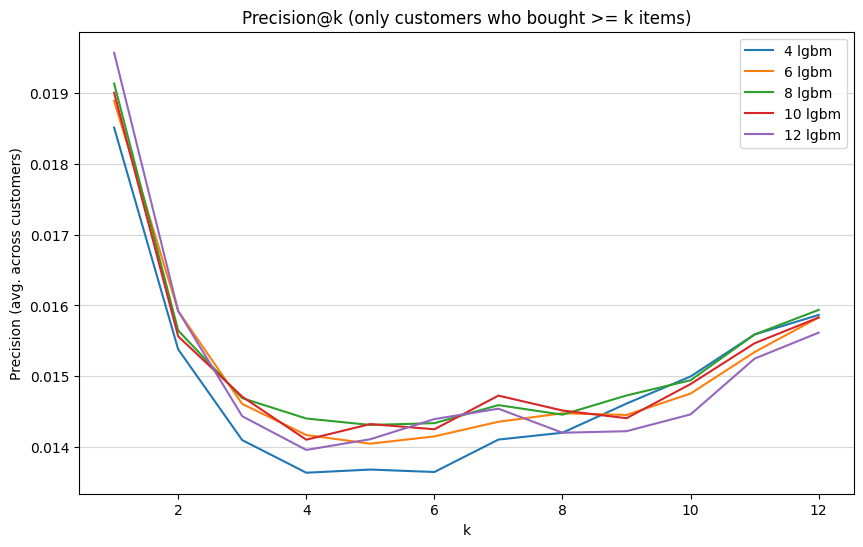

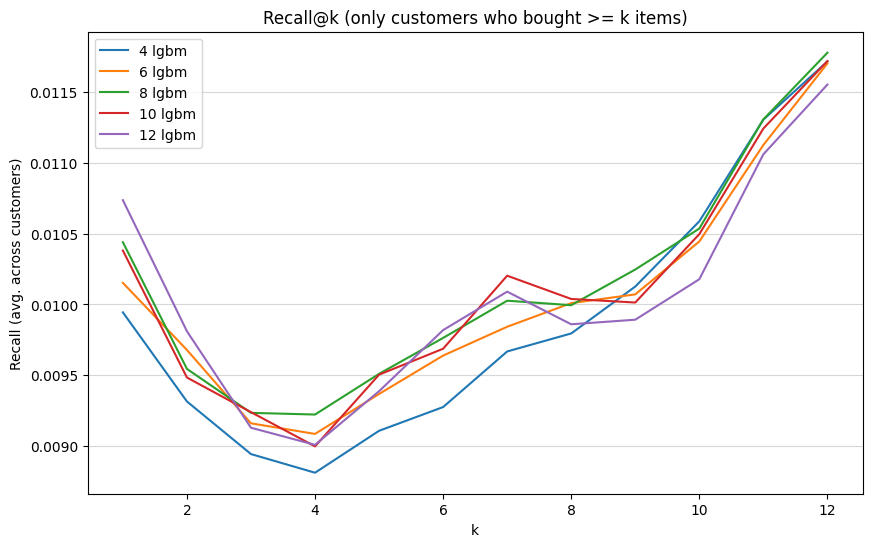

Evaluation plots for adaboost:
Evaluation for 4 adaboost
####################

MAP@12 (all customers):             0.0008410793656835691
MAP@12 (only purchasing customers): 0.016727705962694867

MRR (all customers):                0.001470846228769073
MRR (only purchasing customers):    0.029252748593102645



Evaluation for 6 adaboost
####################

MAP@12 (all customers):             0.0008436062203491771
MAP@12 (only purchasing customers): 0.016777961008272405

MRR (all customers):                0.0014792156539667307
MRR (only purchasing customers):    0.029419202901096998



Evaluation for 8 adaboost
####################

MAP@12 (all customers):             0.0008483080947400294
MAP@12 (only purchasing customers): 0.016871473672466452

MRR (all customers):                0.0014830862304586272
MRR (only purchasing customers):    0.02949618239685474



Evaluation for 10 adaboost
####################

MAP@12 (all customers):             0.0008549362896954159
MAP@12 (only purch

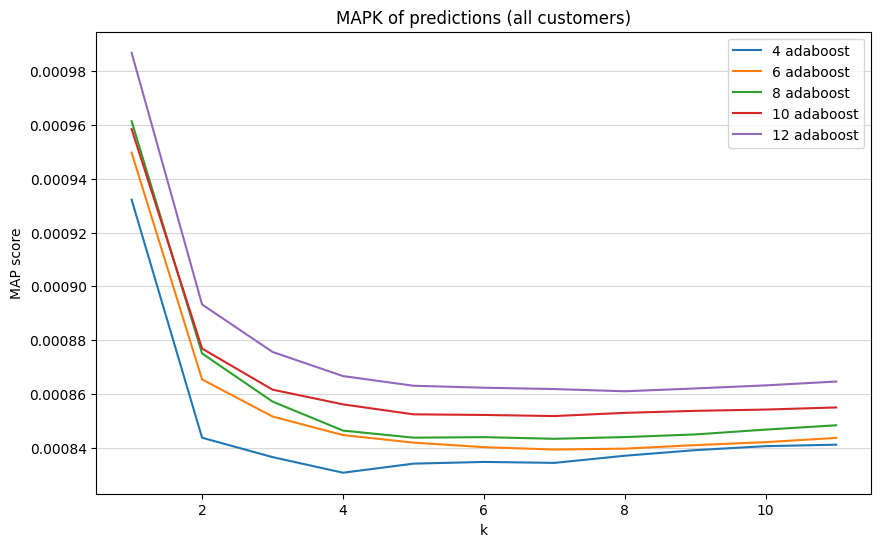

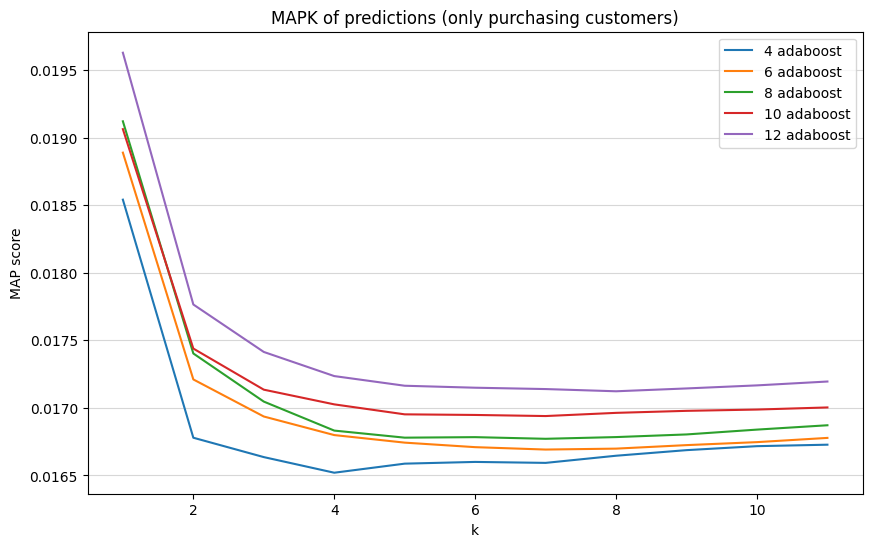

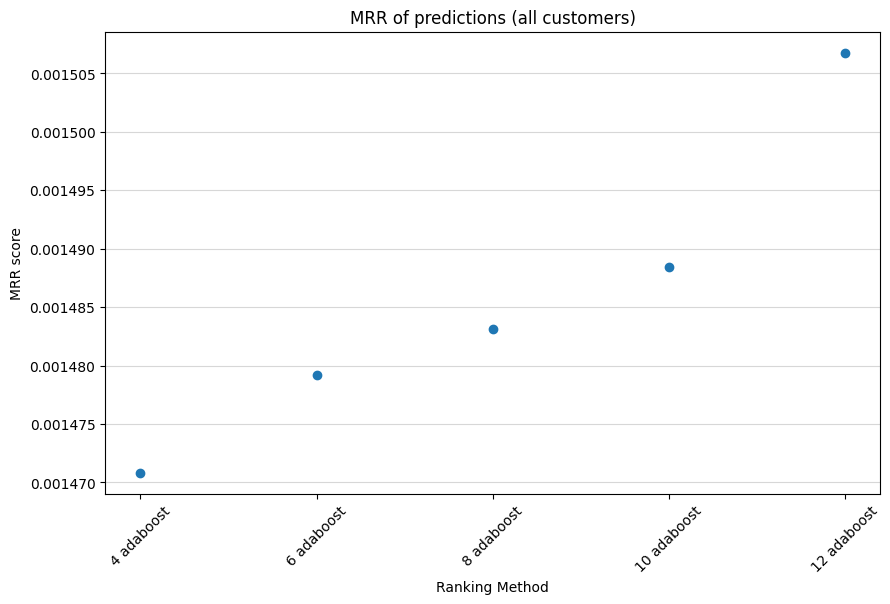

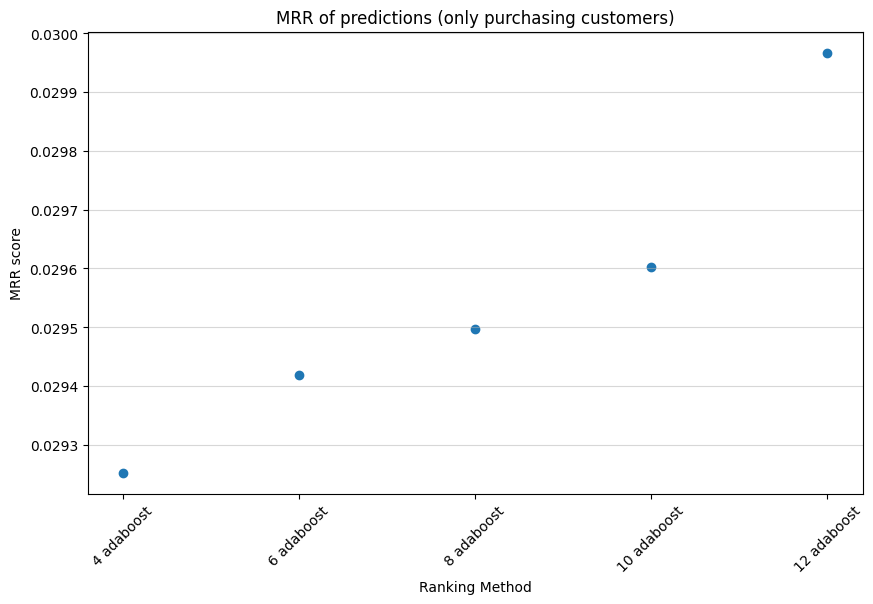

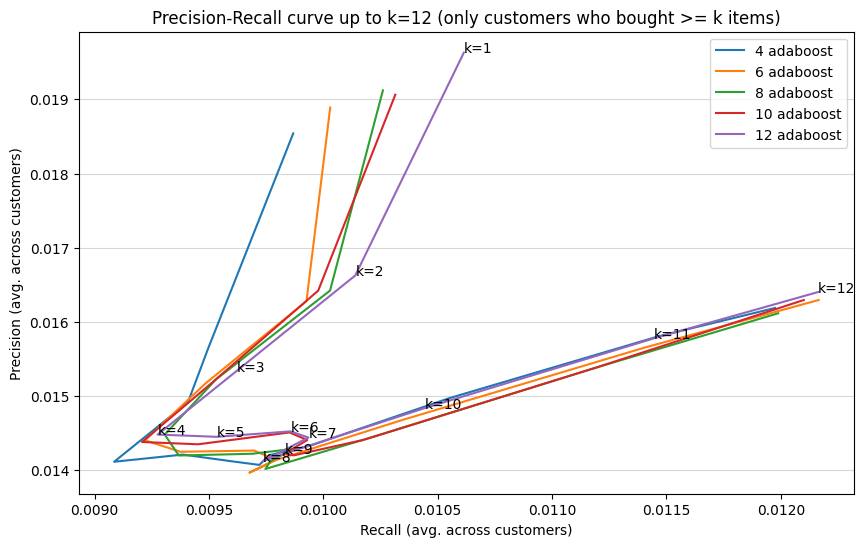

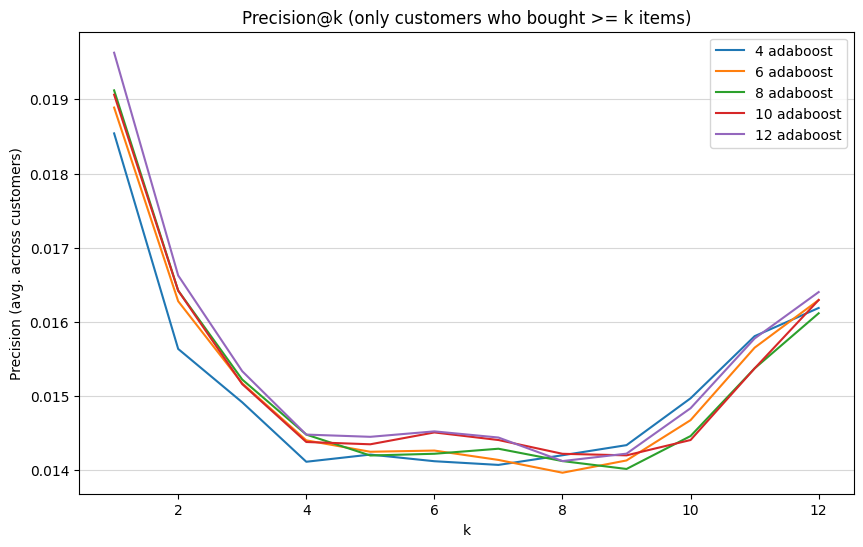

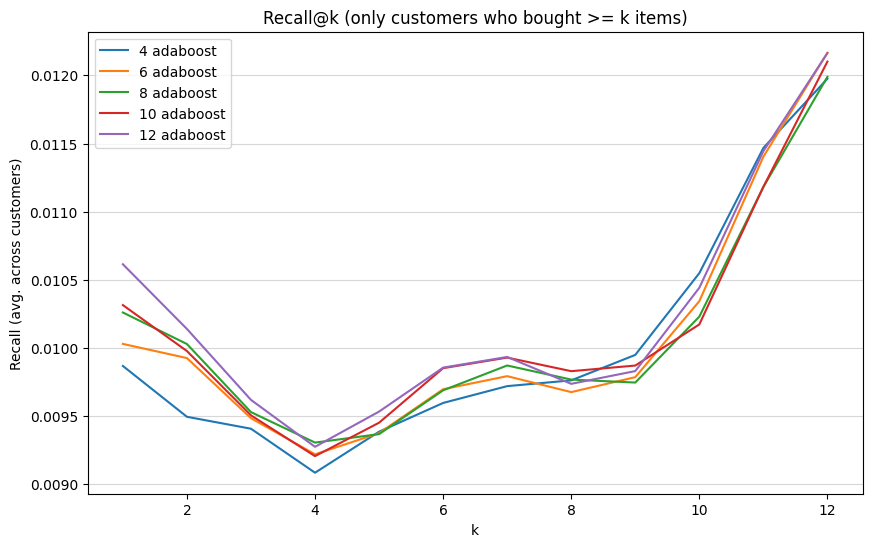

Evaluation plots for naive_bayes:
Evaluation for 4 naive_bayes
####################

MAP@12 (all customers):             0.0005145676437047392
MAP@12 (only purchasing customers): 0.010233916789545801

MRR (all customers):                0.0009226804838803542
MRR (only purchasing customers):    0.018350620002814687



Evaluation for 6 naive_bayes
####################

MAP@12 (all customers):             0.0002723652785227341
MAP@12 (only purchasing customers): 0.005416904134692402

MRR (all customers):                0.0005437456997246515
MRR (only purchasing customers):    0.010814221052827137



Evaluation for 8 naive_bayes
####################

MAP@12 (all customers):             0.00026463005012975014
MAP@12 (only purchasing customers): 0.00526306297368976

MRR (all customers):                0.0005314583422864908
MRR (only purchasing customers):    0.010569845419955638



Evaluation for 10 naive_bayes
####################

MAP@12 (all customers):             0.0002651432020965174
M

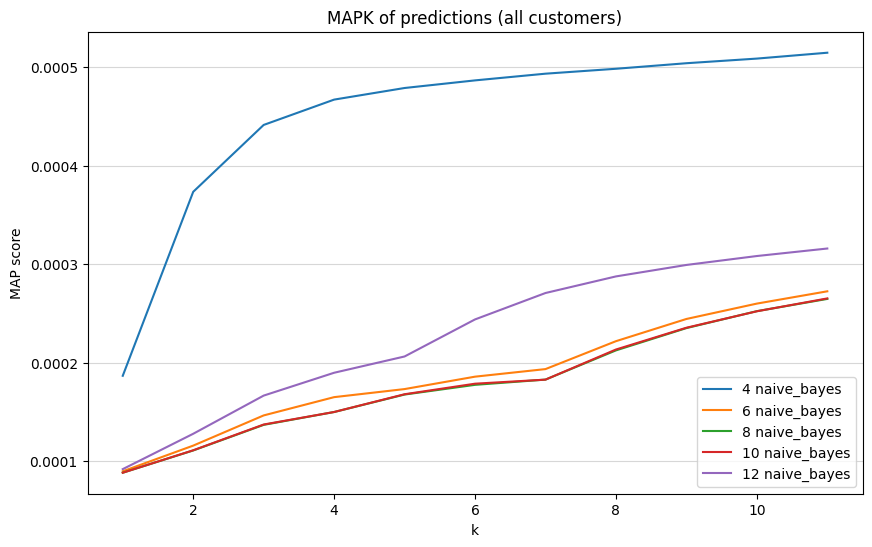

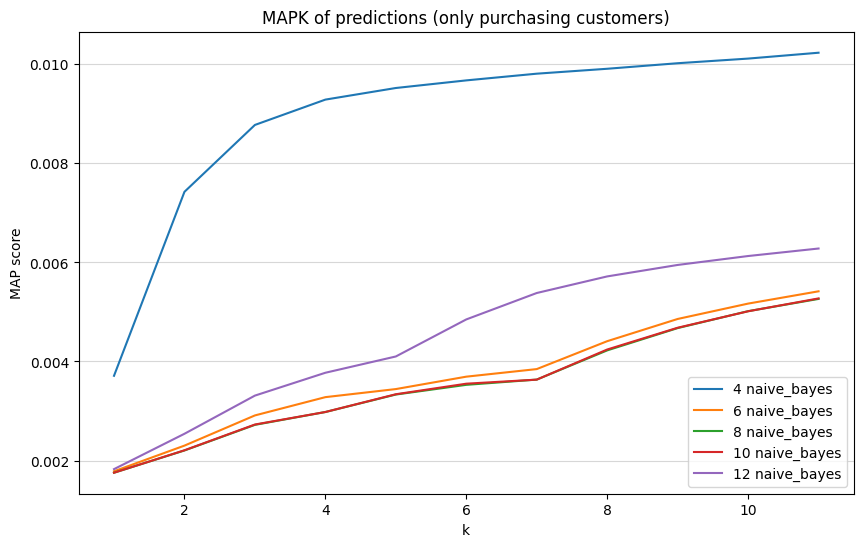

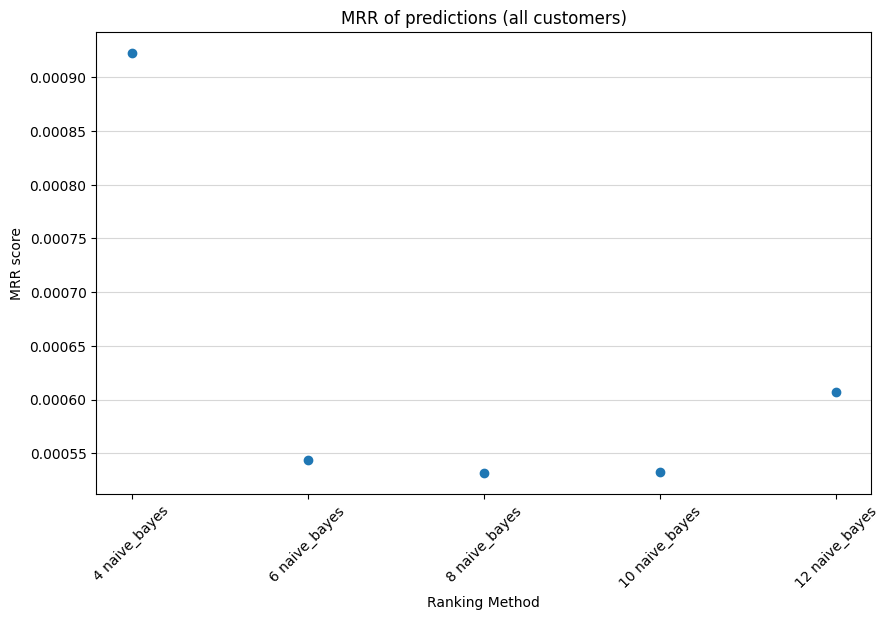

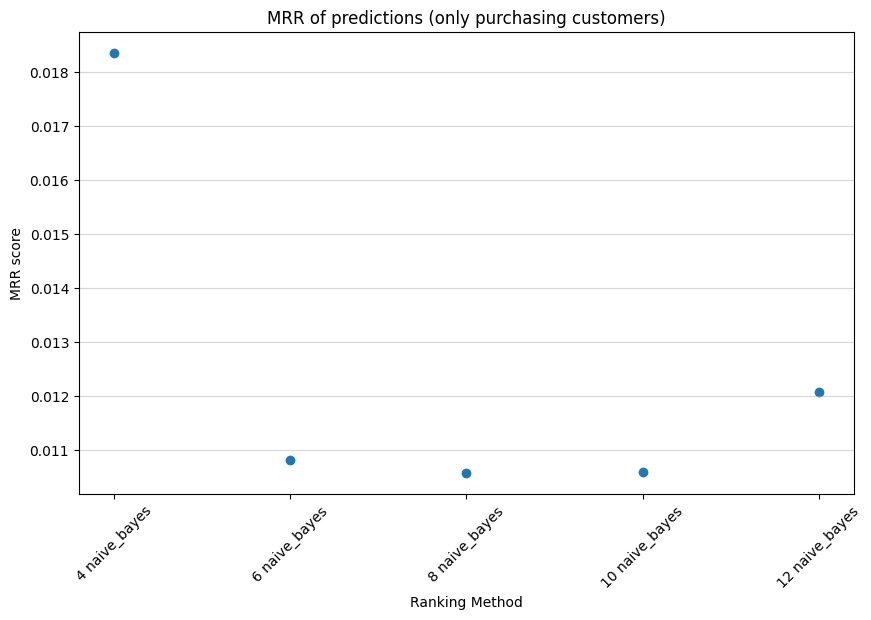

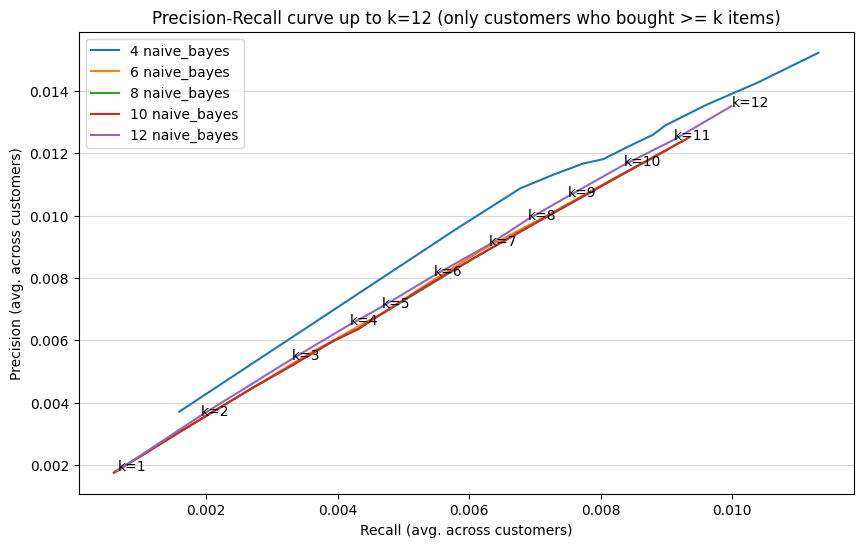

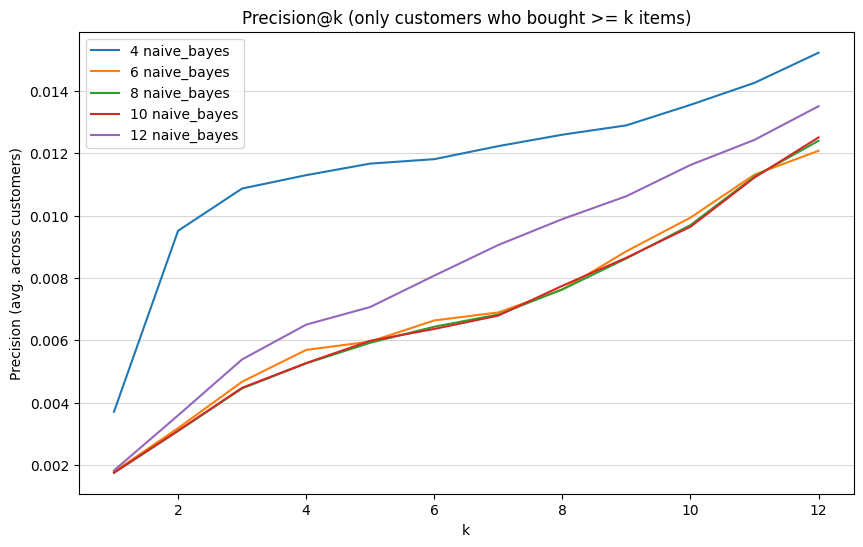

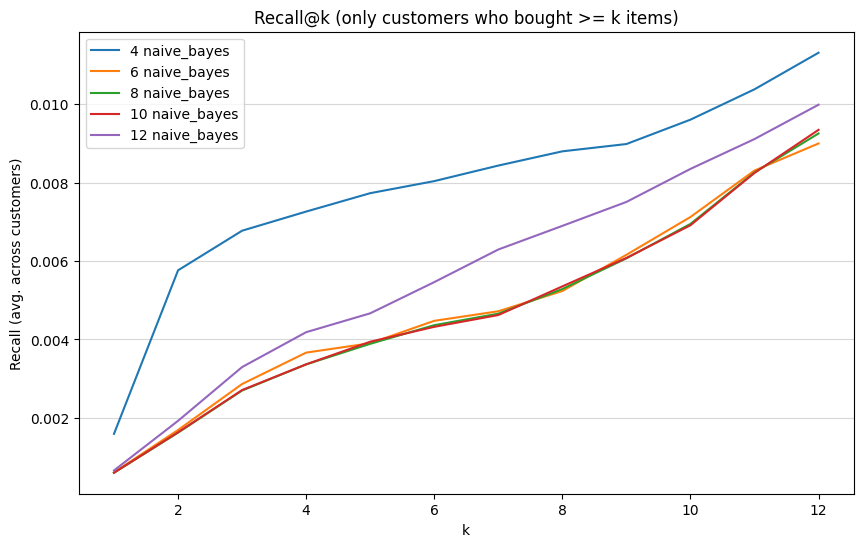

In [11]:
#getting evaluation plots to compare each of the models with varying numbers of training weeks
models = ["stacker_MRR", "stacker_MAPk", "lgbm", "adaboost", "naive_bayes"]
for model in models:
    pred_cols = [f"{nr_training_weeks} {model}" for nr_training_weeks in training_weeks_range]

    print(f"Evaluation plots for {model}:")
    get_evaluation_plots(test, pred_cols, test_week_transactions, None)

GNB and MRR and MAP@12 weighted models perform best with only 2 weeks of training and 2 weeks for validation.

LGBM and AdaBoost perform best with 6 weeks of training and 6 weeks of validation.